# FAKE NEWS CLASSIFIER
## a machine learning approach towards fake news detection

THE BUSINESS PROBLEM:How to distinguish fake news from real news accurately and efficiently to prevent it from spreading?

THE DATA PROBLEM:What model can be used to classify fake and real news from the subtle yet consistent differences in the language of the two classes of articles, and what is the accuracy?


## Importing libraries

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import os
import string
import warnings
import re
import time
import json
import numpy as np
import pandas as pd # for importing files as pandas dataframe
pd.set_option('display.max_colwidth', 50) # display setting

import numpy as np # for numerical computing

import spacy
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from collections import Counter

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from wordcloud import WordCloud
import operator

import matplotlib.pyplot as plt # plotting functions
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score

import warnings
warnings.filterwarnings('ignore')

/Users/Liuyang/opt/anaconda3/envs/withnewpkg/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
! python -m spacy download en_core_web_sm


    Linking successful
    /Users/Liuyang/opt/anaconda3/envs/withnewpkg/lib/python3.7/site-packages/en_core_web_sm
    -->
    /Users/Liuyang/opt/anaconda3/envs/withnewpkg/lib/python3.7/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [4]:
## load spaCy
nlp = spacy.load('en_core_web_sm')

## Text processing

In [5]:
fname = 'data/scraped_articles.json'

In [6]:
with open(fname) as json_data:
    d = json.load(json_data)
#These are the sources that we specified to download from in NewsPapers.json.

In [7]:
for i, site in enumerate((list(d['newspapers']))):
    print(i, site)

0 newyorktimes_business
1 newyorktimes_science
2 newyorktimes_technology
3 newyorktimes_politics
4 newyorktimes_world
5 cnnmoney
6 cnnpolitics
7 marketwatch_newsletters
8 cnbc_top_news
9 theguardian
10 marketwatch_stories
11 cnbc_investing
12 fox_business_latest_headlines
13 fox_business_opinion
14 entrepreneur_latest
15 entrepreneur_marketing
16 reuters_money
17 reuters_science
18 sciencedaily
19 economist_business
20 economist_science_and_tech
21 politifact-true
22 fivethirtyeight_science
23 fivethirtyeight_economics
24 dailymash
25 dailymash_politics
26 nbpostgazette
27 newsthump
28 newsthump_politics
29 newsthump_world
30 newsthump_business
31 waterfordwhispernews
32 waterfordwhispernews_politics
33 clickhole
34 clickhole_news
35 thepoke
36 thepoke_news
37 journalismday
38 satprnews
39 insidertradings
40 the onion
41 the onion_politics
42 highlandmirror
43 thefinancialanalyst
44 reportagestuff
45 huzlers
46 worldnewsdaily
47 100percentfedup
48 100percentfedup_politics
49 politifact

In [8]:
# create a dataframe, with all of the articles, one row per article

for i, site in enumerate((list(d['newspapers']))):
    articles = list(d['newspapers'][site]['articles'])
    if i == 0:
        df = pd.DataFrame.from_dict(articles)
    else:
        new_df = pd.DataFrame.from_dict(articles)
        df = pd.concat([df, new_df], ignore_index = True, sort = True)

In [9]:
df.shape

(2075, 5)

In [10]:
df.head()

,author,link,published,text,title
0,[Kashmir Hill],https://www.nytimes.com/2020/01/18/technology/...,2020-01-18T20:25:19,Mr. Ton-That said his company used only public...,The Secretive Company That Might End Privacy a...
1,[Michael M. Grynbaum],https://www.nytimes.com/2020/01/19/business/me...,2020-01-19T19:18:04,News coverage of President Trump’s impeachment...,Even C-SPAN Is Piqued: Senate Puts Limits on T...
2,[David Gelles],https://www.nytimes.com/2020/01/19/business/da...,2020-01-19T11:00:17,"Last year, one of the most talked-about exchan...","In Its 50th Year, Davos Is Searching for Its Soul"
3,[Nicole Sperling],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:09,The coming out party will feature teenagers fr...,"A New Player at Sundance, Backed by Laurene Po..."
4,[Tiffany Hsu],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:10,“Impeachment” is another no-no. In December 20...,"With Impeachment in the News, Ads Are Staying ..."


In [11]:
df.to_pickle('/Users/Liuyang/Github/DSIA-MEL-PT-201909-LocalMaster/DSIA-MEL-PT-201910-master/Module 9/data/dirty_df.pkl')

In [12]:
# list of spam sites
spam = list(d['newspapers'])[-26:]

In [13]:
# create a column for the label of the article, a label of 0 is ham, a label of 1 is spam
df['label'] = 0

In [14]:
for i, site in enumerate(spam):
    df.loc[df['link'].str.contains('{}'.format(site)), 'label'] = 1

In [15]:
# 1675 non spam articles, 400 spam articles

df[['title', 'label']].groupby('label').agg('count')

,title
label,
0,1675
1,400


In [16]:
df_ham = df[df['label'] == 0]
df_ham.shape

(1675, 6)

In [17]:
df_ham.head()

,author,link,published,text,title,label
0,[Kashmir Hill],https://www.nytimes.com/2020/01/18/technology/...,2020-01-18T20:25:19,Mr. Ton-That said his company used only public...,The Secretive Company That Might End Privacy a...,0
1,[Michael M. Grynbaum],https://www.nytimes.com/2020/01/19/business/me...,2020-01-19T19:18:04,News coverage of President Trump’s impeachment...,Even C-SPAN Is Piqued: Senate Puts Limits on T...,0
2,[David Gelles],https://www.nytimes.com/2020/01/19/business/da...,2020-01-19T11:00:17,"Last year, one of the most talked-about exchan...","In Its 50th Year, Davos Is Searching for Its Soul",0
3,[Nicole Sperling],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:09,The coming out party will feature teenagers fr...,"A New Player at Sundance, Backed by Laurene Po...",0
4,[Tiffany Hsu],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:10,“Impeachment” is another no-no. In December 20...,"With Impeachment in the News, Ads Are Staying ...",0


In [18]:
df_spam = df[df['label'] == 1]
df_spam.shape

(400, 6)

In [19]:
df_spam.head()

,author,link,published,text,title,label
1154,"[Carrie Brunner, About The Author]",https://nbpostgazette.com/what-is-the-wolf-moo...,2020-01-10T09:41:03+05:30,"The first full moon of the year, which is popu...",What Is The ‘Wolf Moon Eclipse’? When And Wher...,1
1155,"[Carrie Brunner, About The Author]",https://nbpostgazette.com/what-is-the-wolf-moo...,2020-01-10T09:41:03+05:30,"The first full moon of the year, which is popu...",What Is The ‘Wolf Moon Eclipse’? When And Wher...,1
1156,"[Carrie Brunner, About The Author]",https://nbpostgazette.com/top-5-mistakes-that-...,2020-01-10T05:17:08+05:30,"Nowadays, technology is growing so fast that i...",Top 5 Mistakes That We All Make While Using Ou...,1
1157,"[Carrie Brunner, About The Author]",https://nbpostgazette.com/top-5-mistakes-that-...,2020-01-10T05:17:08+05:30,"Nowadays, technology is growing so fast that i...",Top 5 Mistakes That We All Make While Using Ou...,1
1158,"[Trey Warsame, About The Author]",https://nbpostgazette.com/planning-to-buy-libr...,2019-07-21T13:22:27+05:30,Facebook’s Libra has been a hot topic since it...,Planning To Buy Libra? Go Through All The Rece...,1


In [20]:
remove_punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~’'
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.sort()
print(', '.join(nltk_stopwords))

a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, her, here, hers, herself, him, himself, his, how, i, if, in, into, is, isn, isn't, it, it's, its, itself, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she's, should, should've, shouldn, shouldn't, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, this, those, through, to, too, under, until, up, ve, very, was, wasn, wasn't, we, were, weren, weren't, what, when, where, which, while, who, whom, why, w

In [21]:
def clean_column(dataframe, column_to_clean, new_col):
    df_copy = dataframe.copy()
    df_copy['copied_column'] = df_copy[column_to_clean]
    df_copy['copied_column'] = df_copy['copied_column'].str.lower()
    cleaned_column = []
    for label in df_copy.index:
        row = df_copy.loc[label, :]['copied_column']
        clean = [x for x in row.split() if x not in string.punctuation]
        clean = [x for x in clean if x not in nltk_stopwords]
        clean = [x for x in clean if x not in string.digits]
        clean = [x for x in clean if x not in remove_punctuation]
        clean = [x for x in clean if len(x) != 1]
        clean = " ".join(clean)
        clean = clean.strip()
        cleaned_column.append(clean)
    df_copy[new_col] = cleaned_column
    del df_copy['copied_column']
    return df_copy

In [22]:
def filtration(dataframe, column):
    # clean = list(map(lambda x: x.replace("#", ""), clean)) #we want to maintain hashtags!
    dataframe[column] = dataframe[column].apply(lambda x: x.replace('"', ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("’", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(":", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("…", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(".",""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("⋆", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ⋆ ", " "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("  ", " "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("$", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(",", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" alime ", " all time "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" alltime ", " all time "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(";", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("alime", "all time "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("atm", "at the moment"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ath ", " all time high "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("str8", "straight"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" v ", " very "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" #d", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ddos ", " distributed denial of service "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("btce", "btc"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("bitcoina", "bitcoin"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("rbitcoin", "bitcoin"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" – ", " "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("-&gt;", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ➤ ", " "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("◄►", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("◄", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ur ", " your "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" u ", " you "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("forthen", "for then"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("&gt;", "greater than"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("&lt;", "less than"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("lt", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("gt", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(":", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("&amp;", "and"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ampamp", "and"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" amp ", " and "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("amp", "and"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" bu ", " but "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("/", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("...", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("(", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(")", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("“", '"'))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("”", '"'))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("‘", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("’", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("-"," "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("*", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("!", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("⬛️", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\u200d", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\U0001f986", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\U0001f942", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\U0001f92f", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\U0001f911", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\U0001F193", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ⭕ ", " "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("🤔", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("☞ ", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("[", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("]", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("{", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("}", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ô", "o"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ó", "o"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("é", "e"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ï","i"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("®", ""))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("á", "a"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ã", "a"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("ç", "c"))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" jan ", " january "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" feb ", " february "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" mar ", " march "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" apr ", " april "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" jun ", " june "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" jul ", " july "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" aug ", " august "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" sept ", " september "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" oct ", " october "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" nov ", " november "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" dec ", " december "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" washinon ", " washington "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" dming ", " direct messaging "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" cust ", " customer "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" wcust ", " with customer "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" cc ", " credit card "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" gopros ", " go pros "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ultimatelyi ", " ultimately i "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 1hr ", " one hour "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" rep ", " representative "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" wunited ", " with united "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" mp# ", " mileage plus number "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" hrs ", " hours "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 4hours ", " four hours "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" laxewr ", " lax ewr "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" iadlax ", " iad lax "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" julystill ", " july still "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 30mins ", " 30 minutes "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" mins ", " minutes "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 5hours ", " 5 hours "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" checkhowever ", " check however "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" familyno ", " family "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 2nd ", " second "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 6hour ", " six hour "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" cuz ", " because "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" cause ", " because "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" ideabuy ", " idea buy "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" fixem ", " fix them "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" properthey ", " proper they "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" americanair ", " american air "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" yea ", " yes "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" gnteed ", " guaranteed "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 6mo ", " 6 months "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" believei ", " believe "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" btw ", " by the way "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" intl ", " international "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" thxs ", " thanks "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" plususual ", " plus usual "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" fridaycant ", " friday can not "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" lhr ", " 1 hour "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" wheelsup ", " wheels up "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" tryna ", " try and "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 2hours ", " 2 hours "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" 1st ", " first "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" creditcard ", " credit card "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" luv ", " love "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" obv ", " obviously "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" patientyou ", " patient you "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" youwe ", " you have "))
    dataframe[column] = dataframe[column].apply(lambda x: x.replace(" uraniumone ", " uranium one "))

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Liuyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

# Function to implement data preparation steps i to iv
def lemma(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [token for token in tokens if len(token) > 1]
    #tokens = [token for token in tokens if not token.isnumeric()]
    tokens = [token for token in tokens if token.isalpha()]
    #text = " ".join([ps.stem(token) for token in tokens if token not in stopwords])
    text = " ".join([wn.lemmatize(token) for token in tokens])
    return text

In [25]:
df1 = df.copy()

In [26]:
# function imported from python module
df1 = clean_column(df1, 'title', 'clean_title')

In [27]:
df1 = clean_column(df1, 'text', 'clean_text')

In [28]:
# function imported from python module
filtration(df1, 'clean_title')

In [29]:
filtration(df1, 'clean_text')

In [30]:
df1['clean_text'] = df1['clean_text'].apply(lambda x: lemma(x))

In [31]:
df1['clean_title'] = df1['clean_title'].apply(lambda x: lemma(x))

In [32]:
df1.head()

,author,link,published,text,title,label,clean_title,clean_text
0,[Kashmir Hill],https://www.nytimes.com/2020/01/18/technology/...,2020-01-18T20:25:19,Mr. Ton-That said his company used only public...,The Secretive Company That Might End Privacy a...,0,secretive company might end privacy know,mr ton that said company used publicly availab...
1,[Michael M. Grynbaum],https://www.nytimes.com/2020/01/19/business/me...,2020-01-19T19:18:04,News coverage of President Trump’s impeachment...,Even C-SPAN Is Piqued: Senate Puts Limits on T...,0,even span piqued senate put limit trial coverage,news coverage president trump impeachment tria...
2,[David Gelles],https://www.nytimes.com/2020/01/19/business/da...,2020-01-19T11:00:17,"Last year, one of the most talked-about exchan...","In Its 50th Year, Davos Is Searching for Its Soul",0,year davos searching soul,last year one talked about exchange event davo...
3,[Nicole Sperling],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:09,The coming out party will feature teenagers fr...,"A New Player at Sundance, Backed by Laurene Po...",0,new player sundance backed laurene powell job,coming party feature teenager texas journalist...
4,[Tiffany Hsu],https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:10,“Impeachment” is another no-no. In December 20...,"With Impeachment in the News, Ads Are Staying ...",0,impeachment news ad staying away politics,impeachment another no no december company blo...


In [33]:
df1_ham = df1[df1['label'] == 0]
df1_ham.shape

(1675, 8)

In [34]:
df1_spam = df1[df1['label'] == 1]
df1_spam.shape

(400, 8)

In [35]:
df1.to_pickle('data/cleaned_df.pkl')

## EDA

In [36]:
word_freq = WordCloud().process_text( ' '.join(df1['clean_text']) ) 
top20 = sorted(word_freq.items(), key=operator.itemgetter(1), reverse=True)[:20]
top20

[('said', 4702),
 ('one', 1987),
 ('state', 1861),
 ('people', 1532),
 ('time', 1343),
 ('say', 1274),
 ('new', 1199),
 ('trump', 1156),
 ('year', 991),
 ('well', 986),
 ('even', 943),
 ('may', 927),
 ('many', 911),
 ('number', 893),
 ('country', 862),
 ('make', 832),
 ('first', 828),
 ('united state', 828),
 ('company', 827),
 ('thats', 779)]

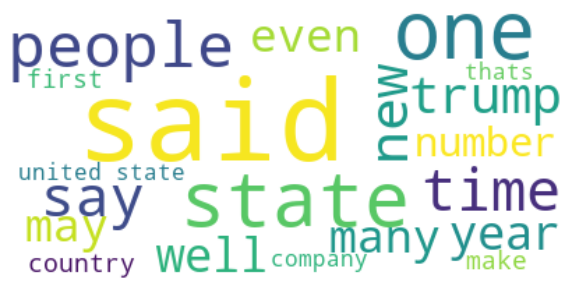

In [37]:
# plot top 20 word frequencies
wordcloud = WordCloud(max_font_size=80, max_words=20, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

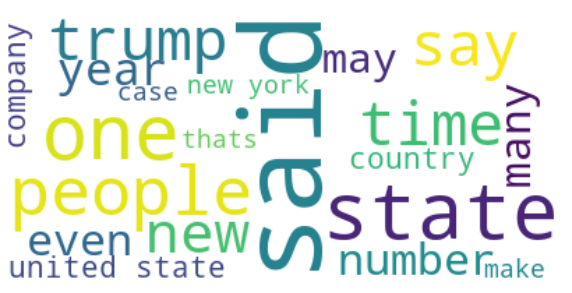

In [38]:
# plot top 20 word frequencies of real news
word_freq = WordCloud().process_text( ' '.join(df1_ham['clean_text']) ) 
wordcloud = WordCloud(max_font_size=80, max_words=20, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

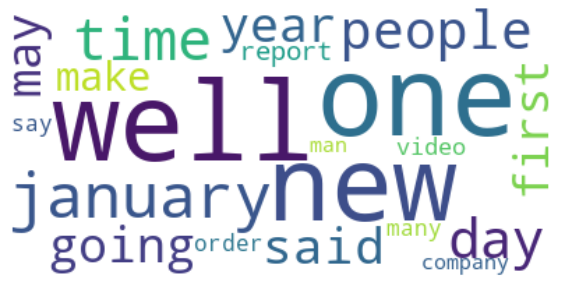

In [39]:
# plot top 20 word frequencies of fake news
word_freq = WordCloud().process_text( ' '.join(df1_spam['clean_text']) ) 
wordcloud = WordCloud(max_font_size=80, max_words=20, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
%%time
df1['char_count'] = df1['text'].apply(len)
df1['word_count'] = df1['text'].apply(lambda x: len(x.split()))
df1['word_density'] = df1['char_count'] / (df1['word_count'] + 1)
df1['punctuation_count'] = df1['text'].apply(lambda x: len(''.join(_ for _ in x if _ in string.punctuation))) 
df1['title_word_count'] = df1['text'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df1['uppercase_word_count'] = df1['text'].apply(lambda x: len([w for w in x.split() if w.isupper()]))

CPU times: user 1.48 s, sys: 44.2 ms, total: 1.52 s
Wall time: 2.03 s


In [41]:
# Initialise some columns for feature's counts
df1['adj_count'] = 0
df1['adv_count'] = 0
df1['noun_count'] = 0
df1['num_count'] = 0
df1['pron_count'] = 0
df1['propn_count'] = 0
df1['verb_count'] = 0

In [42]:
%%time
# for each text
for i in range(df1.shape[0]):
    # convert into a spaCy document
    doc = nlp(df1.iloc[i]['text'])
    # initialise feature counters
    c = Counter([t.pos_ for t in doc])

    df1.at[i, 'adj_count'] = c['ADJ']
    df1.at[i, 'adv_count'] = c['ADV']
    df1.at[i, 'noun_count'] = c['NOUN']
    df1.at[i, 'num_count'] = c['NUM']
    df1.at[i, 'pron_count'] = c['PRON']
    df1.at[i, 'propn_count'] = c['PROPN']
    df1.at[i, 'verb_count'] = c['VERB']

CPU times: user 7min 39s, sys: 1min, total: 8min 40s
Wall time: 4min 38s


In [43]:
cols = [
    'char_count', 'word_count', 'word_density',
    'punctuation_count', 'title_word_count',
    'uppercase_word_count', 'adj_count',
    'adv_count', 'noun_count', 'num_count',
    'pron_count', 'propn_count', 'verb_count']

df1[cols].head()

,char_count,word_count,word_density,punctuation_count,title_word_count,uppercase_word_count,adj_count,adv_count,noun_count,num_count,pron_count,propn_count,verb_count
0,1898,330,5.734139,40,40,3,29,24,72,3,21,25,72
1,909,146,6.183673,13,19,2,10,9,34,1,4,16,28
2,2362,383,6.151042,56,46,3,34,28,91,4,14,31,74
3,977,153,6.344156,21,33,1,8,1,35,9,2,33,21
4,2017,330,6.093656,58,52,3,38,14,77,5,11,41,62


## Baseline Modelling

In [44]:
baseline_accuracy= pd.DataFrame(df1['label'].value_counts(1))
baseline_accuracy

,label
0,0.807229
1,0.192771


In [45]:
# Features and Labels
X = df1['clean_text']
y = df1['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Feature Engineering

### Count Vectors as features

In [46]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(df1['text'])

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

### TF-IDF Vectors as features
- Word level
- N-Gram level
- Character level

In [47]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(df1['text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
CPU times: user 2.05 s, sys: 36.5 ms, total: 2.09 s
Wall time: 2.64 s


In [48]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(df1['text'])
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
CPU times: user 8.61 s, sys: 273 ms, total: 8.88 s
Wall time: 9.59 s


In [49]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(df1['text'])
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
CPU times: user 13.1 s, sys: 163 ms, total: 13.3 s
Wall time: 13.3 s


In [50]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(predictions, y_test)

In [51]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

In [52]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.8675

CPU times: user 8.64 ms, sys: 2.82 ms, total: 11.5 ms
Wall time: 10.8 ms


In [53]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.8217

CPU times: user 5.69 ms, sys: 1.42 ms, total: 7.11 ms
Wall time: 6.22 ms


In [54]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.8289

CPU times: user 2.94 ms, sys: 186 µs, total: 3.12 ms
Wall time: 3.33 ms


In [55]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(MultinomialNB(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('NB, CharLevel Vectors: %.4f\n' % accuracy4)

NB, CharLevel Vectors: 0.7831

CPU times: user 18.2 ms, sys: 2.48 ms, total: 20.6 ms
Wall time: 19.2 ms


In [56]:
results.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [57]:
%%time
# Linear Classifier on Count Vectors
accuracy1 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350, random_state = 0), X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.9639

CPU times: user 557 ms, sys: 15 ms, total: 572 ms
Wall time: 440 ms


In [58]:
classifier = LogisticRegression(solver = 'lbfgs', max_iter = 350,random_state = 0)
classifier.fit(X_train_count, y_train)
actual = y_test
predictions = classifier.predict(X_test_count)
accuracy_ = accuracy_score(actual, predictions)
precision_ = precision_score(actual, predictions)
recall_ = recall_score(actual, predictions)
fpr, tpr, _ = roc_curve(actual, predictions)
roc_auc = auc(fpr, tpr)
roc_auc_ = roc_auc_score(actual, predictions)
print ('LR, Count Vectors Accuracy: %.4f\n' % accuracy_, 'Precision: %.4f\n' % precision_,'Recall: %.4f\n' % 
       recall_, 'ROC_AUC: %.4f\n' % roc_auc)

LR, Count Vectors Accuracy: 0.9639
 Precision: 1.0000
 Recall: 0.8333
 ROC_AUC: 0.9167



In [59]:
%%time
# Linear Classifier on Word Level TF IDF Vectors
accuracy2 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350, random_state = 0), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF : 0.8602

CPU times: user 96.3 ms, sys: 8.97 ms, total: 105 ms
Wall time: 151 ms


In [60]:
%%time
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350, random_state = 0), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors   : %.4f\n' % accuracy3)

LR, N-Gram Vectors   : 0.8337

CPU times: user 88.4 ms, sys: 8.21 ms, total: 96.6 ms
Wall time: 135 ms


In [61]:
%%time
# Linear Classifier on Character Level TF IDF Vectors
accuracy4 = train_model(LogisticRegression(solver = 'lbfgs', max_iter = 350, random_state = 0), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors: %.4f\n' % accuracy4)

LR, CharLevel Vectors: 0.8434

CPU times: user 338 ms, sys: 7.34 ms, total: 345 ms
Wall time: 266 ms


In [62]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [63]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(LinearSVC(random_state = 0), X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.9542

CPU times: user 479 ms, sys: 7.17 ms, total: 486 ms
Wall time: 501 ms


In [64]:
%%time
# Support Vector Machine on Word Level TF IDF Vectors
accuracy2 = train_model(LinearSVC(random_state = 0), X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF : 0.9470

CPU times: user 26.2 ms, sys: 2.08 ms, total: 28.2 ms
Wall time: 26.4 ms


In [65]:
%%time
# Support Vector Machine on Ngram Level TF IDF Vectors
accuracy3 = train_model(LinearSVC(random_state = 0), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors   : %.4f\n' % accuracy3)

SVM, N-Gram Vectors   : 0.8651

CPU times: user 6.68 ms, sys: 1.54 ms, total: 8.22 ms
Wall time: 8.14 ms


In [66]:
%%time
# Support Vector Machine on Character Level TF IDF Vectors
accuracy4 = train_model(LinearSVC(random_state = 0), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, CharLevel Vectors: %.4f\n' % accuracy4)

SVM, CharLevel Vectors: 0.9470

CPU times: user 188 ms, sys: 13 ms, total: 201 ms
Wall time: 251 ms


In [67]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [68]:
%%time
# Bagging (Random Forest) on Count Vectors
accuracy1 = train_model(RandomForestClassifier(n_estimators = 500,random_state = 0), X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.9349

CPU times: user 8.39 s, sys: 45.2 ms, total: 8.44 s
Wall time: 8.49 s


In [70]:
#check feature importance to see which words are shaping the models most
count_dict = count_vect.vocabulary_
model = RandomForestClassifier(n_estimators = 500,random_state = 0)
model.fit(X_train_count, y_train)
feature_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)[:20]
feature_imp = list(feature_imp.index)
list_feature = []
for i in feature_imp:
    a = list(count_dict.keys())[list(count_dict.values()).index(i)]
    list_feature.append(a)

list_feature

['williams',
 'said',
 'simon',
 'rate',
 'meghan',
 'state',
 'ruling',
 'best',
 'brexit',
 'well',
 'amazing',
 'whilst',
 'going',
 'january',
 'claim',
 'order',
 'bong',
 'hence',
 'year',
 'video']

In [71]:
%%time
# Bagging (Random Forest) on Word Level TF IDF Vectors
accuracy2 = train_model(RandomForestClassifier(n_estimators = 500,random_state = 0), X_train_tfidf, y_train, X_test_tfidf)
print('RF, WordLevel TF-IDF : %.4f\n' % accuracy2)

RF, WordLevel TF-IDF : 0.9325

CPU times: user 7.06 s, sys: 54.5 ms, total: 7.11 s
Wall time: 8.04 s


In [72]:
%%time
# Bagging (Random Forest) on Ngram Level TF IDF Vectors
accuracy3 = train_model(RandomForestClassifier(n_estimators = 500,random_state = 0), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.9012

CPU times: user 5.8 s, sys: 70.2 ms, total: 5.87 s
Wall time: 6.29 s


In [73]:
%%time
# Bagging (Random Forest) on Character Level TF IDF Vectors
accuracy4 = train_model(RandomForestClassifier(n_estimators = 500,random_state = 0), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('RF, CharLevel Vectors: %.4f\n' % accuracy4)

RF, CharLevel Vectors: 0.9325

CPU times: user 21.4 s, sys: 140 ms, total: 21.5 s
Wall time: 22.5 s


In [74]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [75]:
%%time
# Gradient Boosting on Count Vectors
accuracy1 = train_model(GradientBoostingClassifier(), X_train_count, y_train, X_test_count)
print('GB, Count Vectors    : %.4f\n' % accuracy1)

GB, Count Vectors    : 0.8988

CPU times: user 8.35 s, sys: 87.2 ms, total: 8.44 s
Wall time: 9.61 s


In [76]:
%%time
# Gradient Boosting on Word Level TF IDF Vectors
accuracy2 = train_model(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf)
print('GB, WordLevel TF-IDF : %.4f\n' % accuracy2)

GB, WordLevel TF-IDF : 0.9133

CPU times: user 6.29 s, sys: 26.5 ms, total: 6.31 s
Wall time: 6.76 s


In [77]:
%%time
# Gradient Boosting on Ngram Level TF IDF Vectors
accuracy3 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('GB, N-Gram Vectors   : %.4f\n' % accuracy3)

GB, N-Gram Vectors   : 0.8506

CPU times: user 590 ms, sys: 10.4 ms, total: 601 ms
Wall time: 696 ms


In [78]:
%%time
# Gradient Boosting on Character Level TF IDF Vectors
accuracy4 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('GB, CharLevel Vectors: %.4f\n' % accuracy4)

GB, CharLevel Vectors: 0.9349

CPU times: user 46.8 s, sys: 349 ms, total: 47.2 s
Wall time: 49.6 s


In [79]:
results.loc['Gradient Boosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [80]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Naïve Bayes,0.867470,0.821687,0.828916,0.783133
Logistic Regression,0.963855,0.860241,0.833735,0.843373
Support Vector Machine,0.954217,0.946988,0.865060,0.946988
Random Forest,0.934940,0.932530,0.901205,0.932530
Gradient Boosting,0.898795,0.913253,0.850602,0.934940


## Model Improvement

In [81]:
# helper function to show results and charts
def show_summary_report(actual, prediction):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

*********
* Count *
*********
Accuracy : 0.9590 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9740 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8333 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9136                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


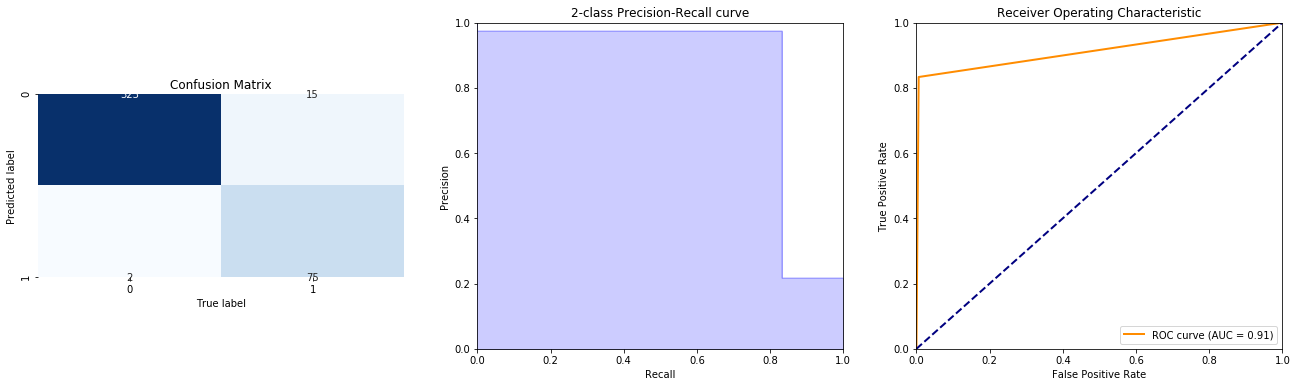


**********
* TF-IDX *
**********
Accuracy : 0.9542 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9277 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8556 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9185                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


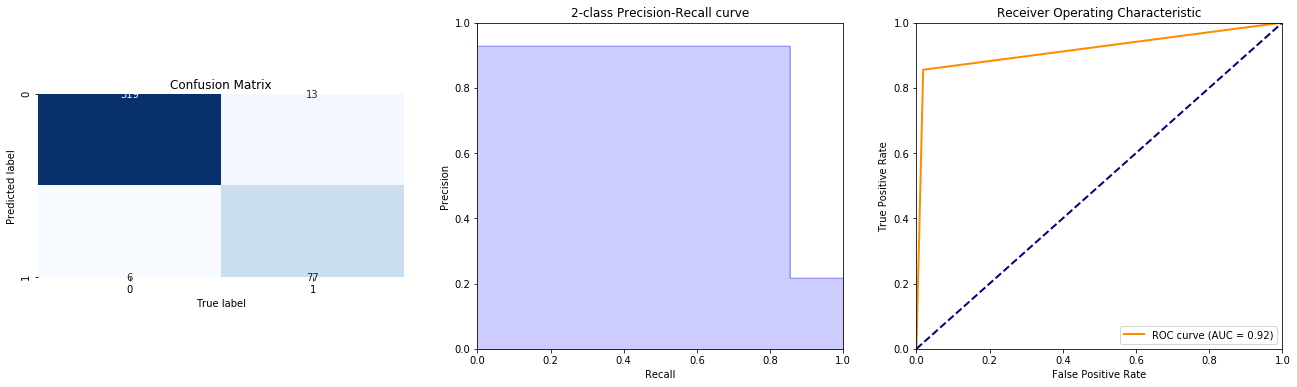

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.959036,0.974026,0.833333,0.913590
1,TF-IDX,0.954217,0.927711,0.855556,0.918547


In [82]:
# LR - increasing max_iter from 350 to 1000, adding classweight
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_train, y_train)
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000, class_weight={1: 4},random_state = 0)
    classifier.fit(A.toarray(), y_train)
    B = counts.transform(X_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9663 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9872 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8556 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9262                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


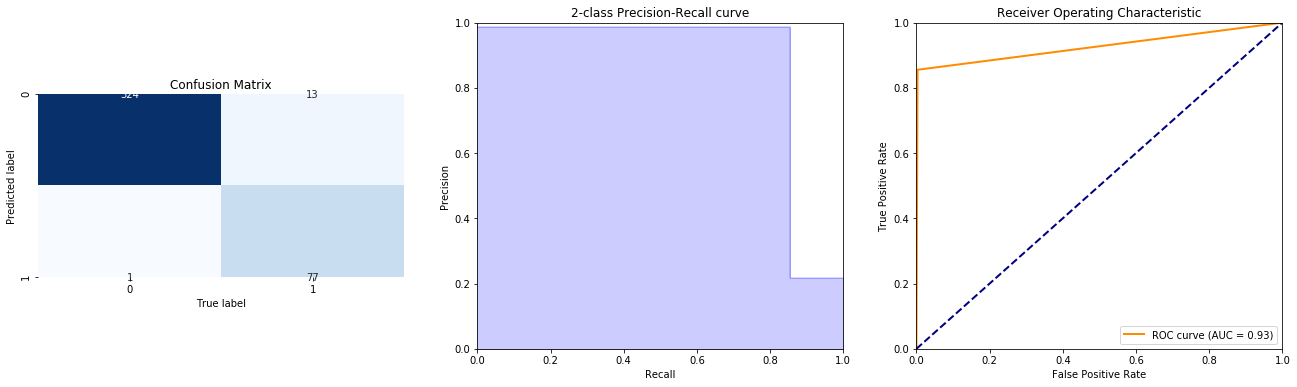


**********
* TF-IDX *
**********
Accuracy : 0.9566 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8444 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9161                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


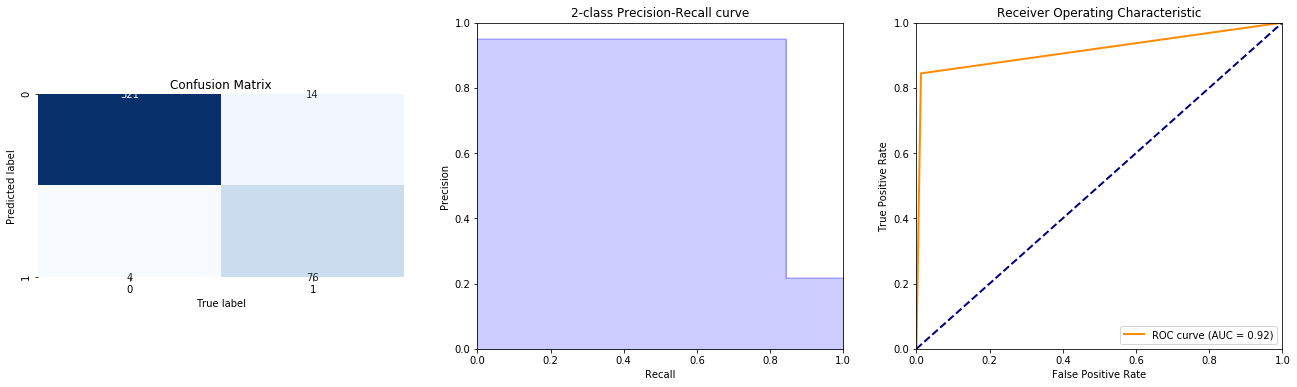

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.966265,0.987179,0.855556,0.926239
1,TF-IDX,0.956627,0.950000,0.844444,0.916068


In [83]:
# SVM - increasing max_iter from 1000 to 2000, adding class weight
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_train, y_train)
    classifier = LinearSVC(C=1.0, class_weight={1: 4}, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000, penalty='l2', random_state=0, tol=0.0001,verbose=0)
    classifier.fit(A.toarray(), y_train)
    B = counts.transform(X_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9325 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6889 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8444                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


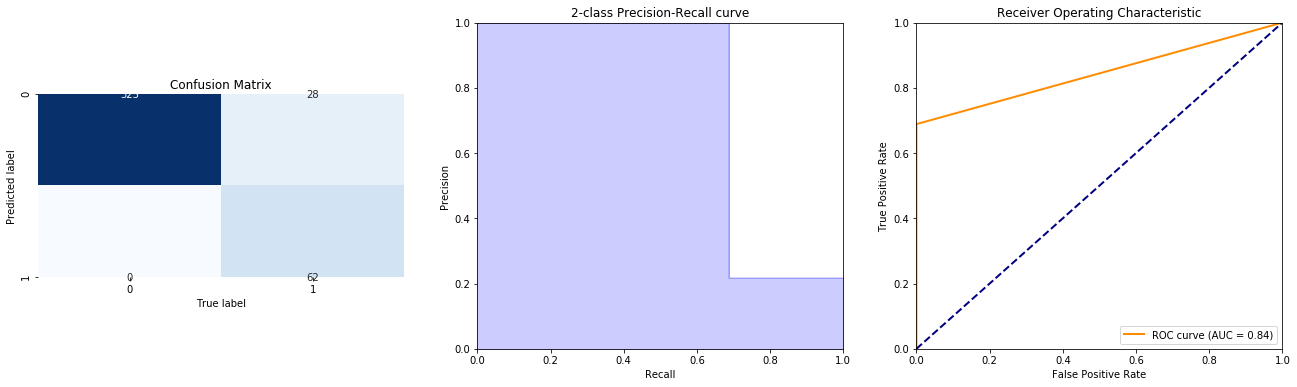


**********
* TF-IDX *
**********
Accuracy : 0.9349 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8500                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


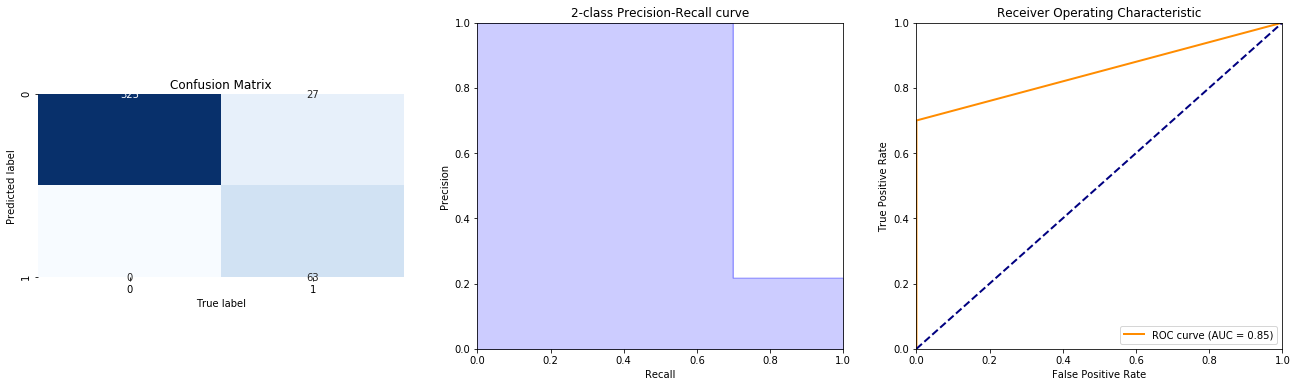

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.93253,1.0,0.688889,0.844444
1,TF-IDX,0.93494,1.0,0.700000,0.850000


In [84]:
# randomforest - increasing n_estimator from 500 to 1000, adding class weight
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_train, y_train)
    classifier = RandomForestClassifier(n_estimators = 1000, class_weight={1: 4}, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    classifier.fit(A.toarray(), y_train)
    B = counts.transform(X_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

In [85]:
#check feature importance to see which words are shaping the models most
count_dict = count_vect.vocabulary_
model = RandomForestClassifier(n_estimators = 1000, class_weight={1: 4}, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
model.fit(X_train_count, y_train)
feature_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)[:20]
feature_imp = list(feature_imp.index)
list_feature = []
for i in feature_imp:
    a = list(count_dict.keys())[list(count_dict.values()).index(i)]
    list_feature.append(a)
list_feature

['said',
 'ruling',
 'rate',
 'university',
 'williams',
 'share',
 'state',
 'simon',
 'claim',
 'politifact',
 'published',
 'fact',
 'true',
 'data',
 'it',
 'would',
 'year',
 'professor',
 'cnn',
 'research']

*********
* Count *
*********
Accuracy : 0.9373 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7111 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8556                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


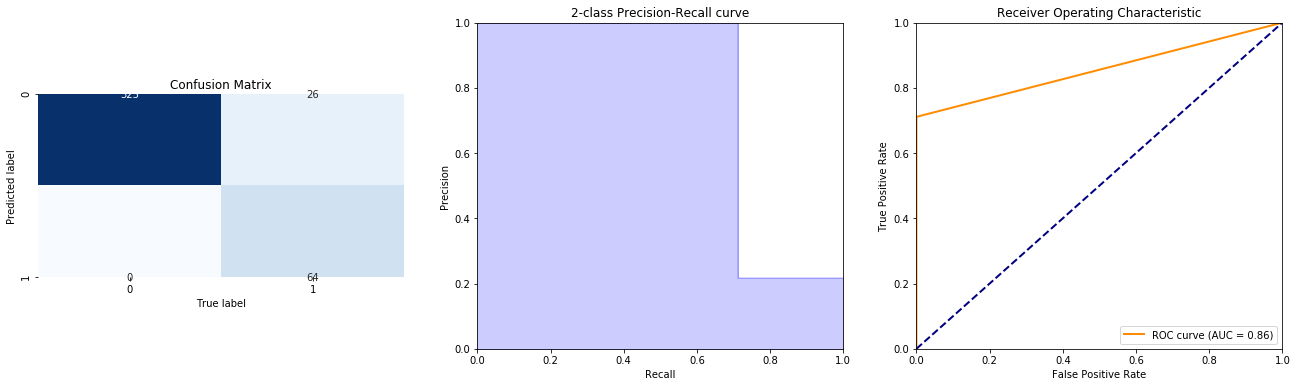


**********
* TF-IDX *
**********
Accuracy : 0.9373 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7111 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8556                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


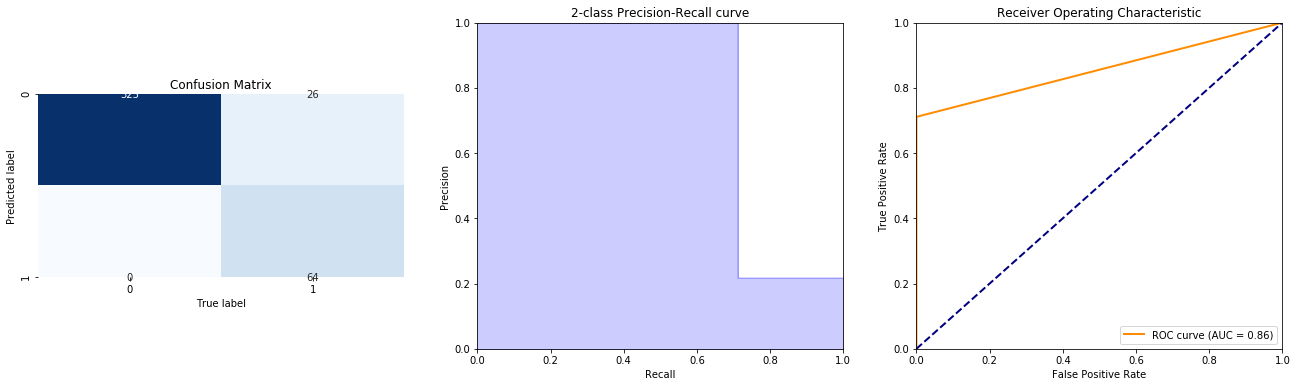

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.937349,1.0,0.711111,0.855556
1,TF-IDX,0.937349,1.0,0.711111,0.855556


In [86]:
# randomforest - increasing n_estimator from 500 to 1000, adding class weight, changed criterion to entropy
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
 
    counts = m
    A = counts.fit_transform(X_train, y_train)
    classifier = RandomForestClassifier(n_estimators = 1000, class_weight={1: 4}, criterion='entropy', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    classifier.fit(A.toarray(), y_train)
    B = counts.transform(X_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

### Applying SMOTE

In [87]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [88]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [89]:
# Features and Labels
X = df1['clean_text']
y = df1['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [90]:
y_train.value_counts()

0    1350
1     310
Name: label, dtype: int64

*********
* Count *
*********
Accuracy : 0.9373 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8810 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8222 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8957                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


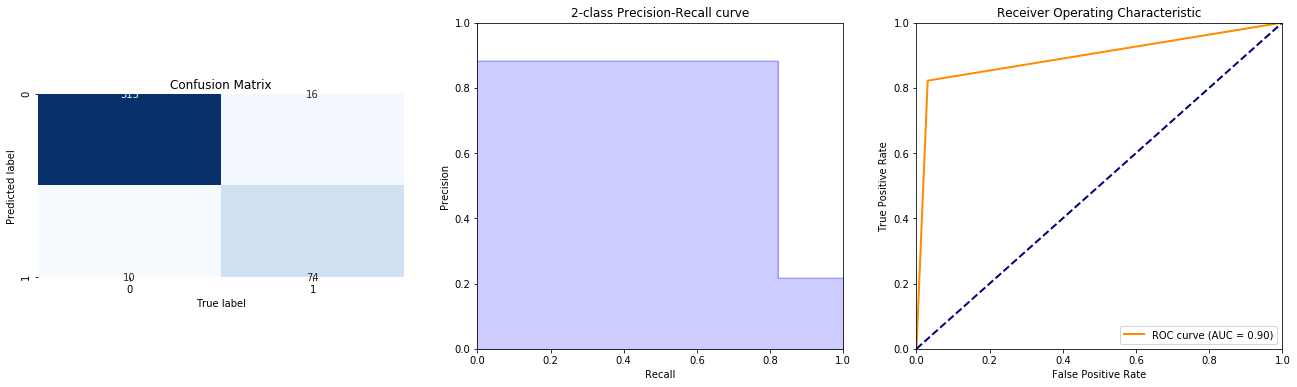


**********
* TF-IDX *
**********
Accuracy : 0.9253 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7980 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8778 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9081                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


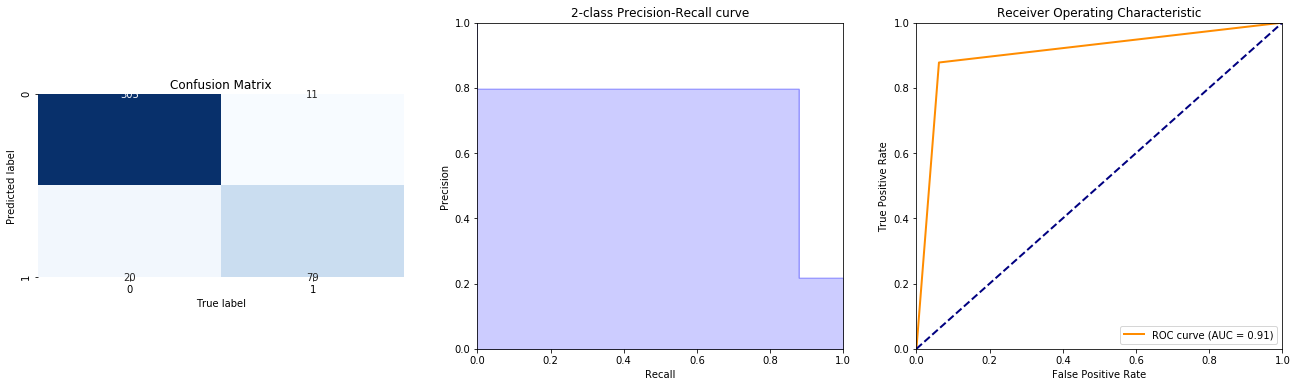

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.937349,0.880952,0.822222,0.895726
1,TF-IDX,0.925301,0.797980,0.877778,0.908120


In [91]:
#LR - 1000 iteration, applied SMOTE
smt = SMOTE()
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = smt.fit_sample(A.toarray(), y_train)
    
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000,random_state = 0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    
    print()

results

In [92]:
np.bincount(y_train)

array([1350, 1350])

*********
* Count *
*********
Accuracy : 0.9446 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9036 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8333 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9044                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


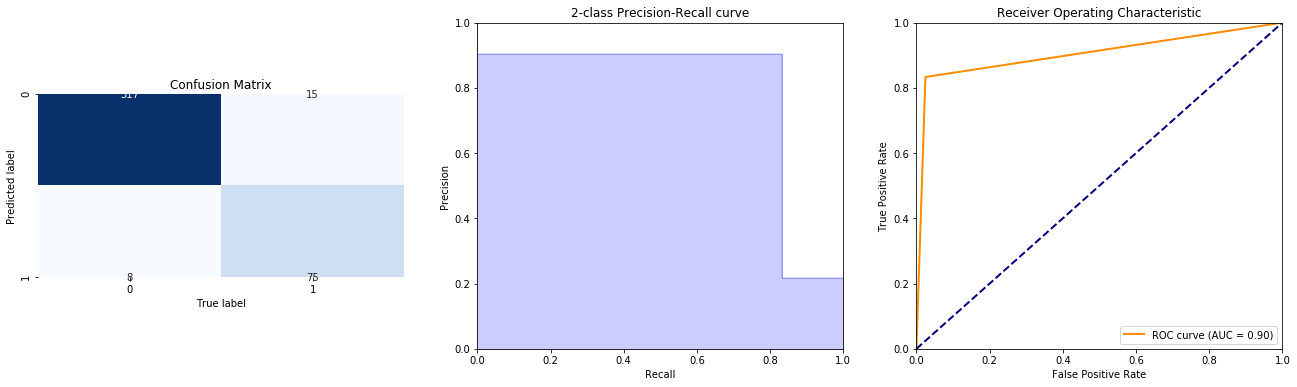


**********
* TF-IDX *
**********
Accuracy : 0.9253 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7921 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8889 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9121                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


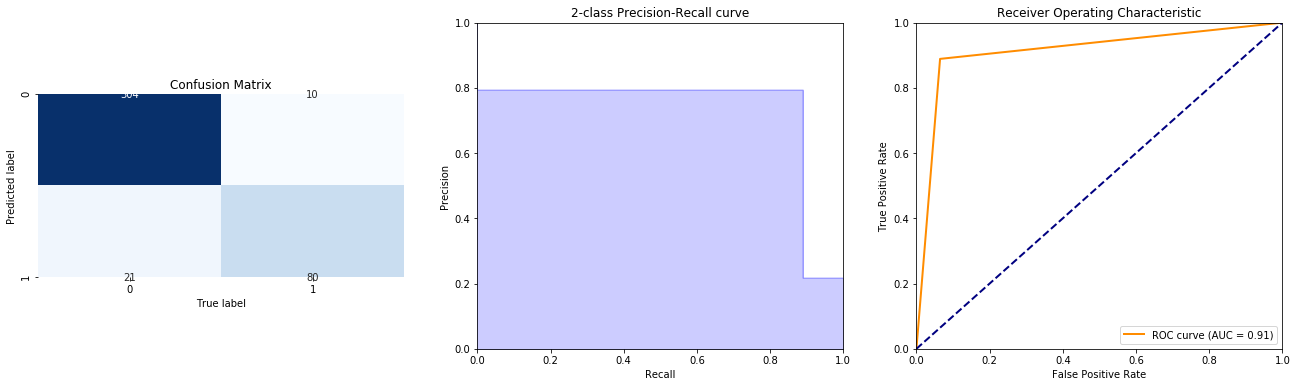

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.944578,0.903614,0.833333,0.904359
1,TF-IDX,0.925301,0.792079,0.888889,0.912137


In [93]:
#SVM - 2000 iteration, applying SMOTE
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = smt.fit_sample(A.toarray(), y_train)
    
    Classifier = LinearSVC(C=1.0, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,verbose=0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    
    print()

results

*********
* Count *
*********
Accuracy : 0.9205 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8519 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7667 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8649                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


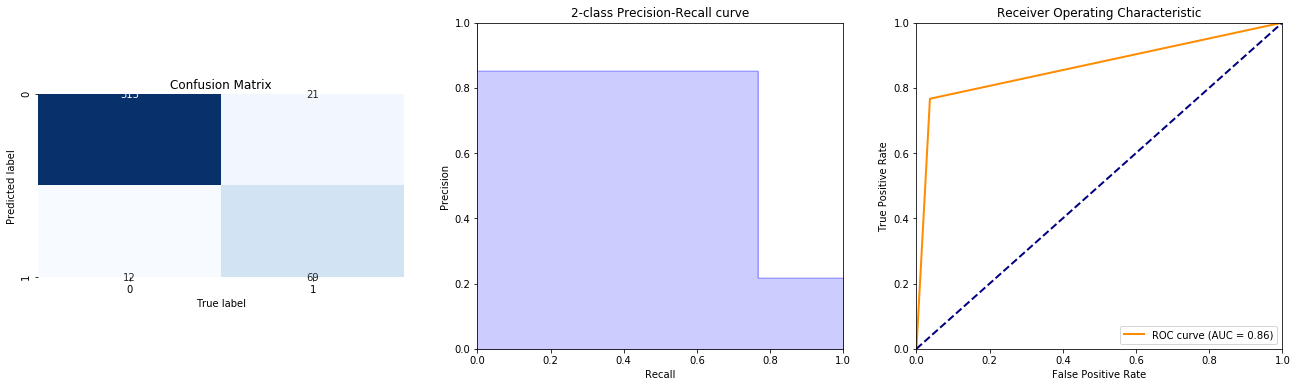


**********
* TF-IDX *
**********
Accuracy : 0.9470 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7556 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8778                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


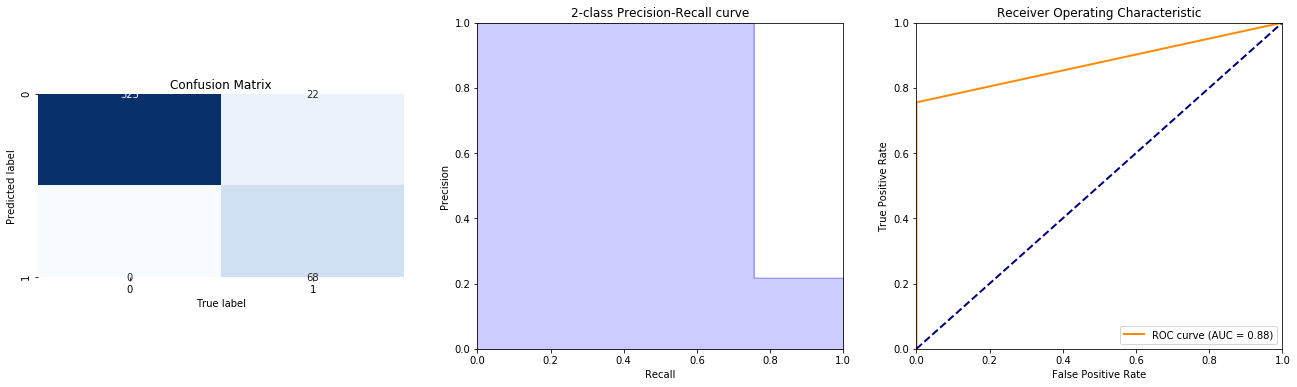

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.920482,0.851852,0.766667,0.864872
1,TF-IDX,0.946988,1.000000,0.755556,0.877778


In [94]:
# randomforest - increasing n_estimator from 500 to 1000, applying SMOTE
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = smt.fit_sample(A.toarray(), y_train)
    
    classifier = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

### Applying NearMiss

In [95]:
from imblearn.under_sampling import NearMiss

*********
* Count *
*********
Accuracy : 0.6723 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.3894 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7546                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


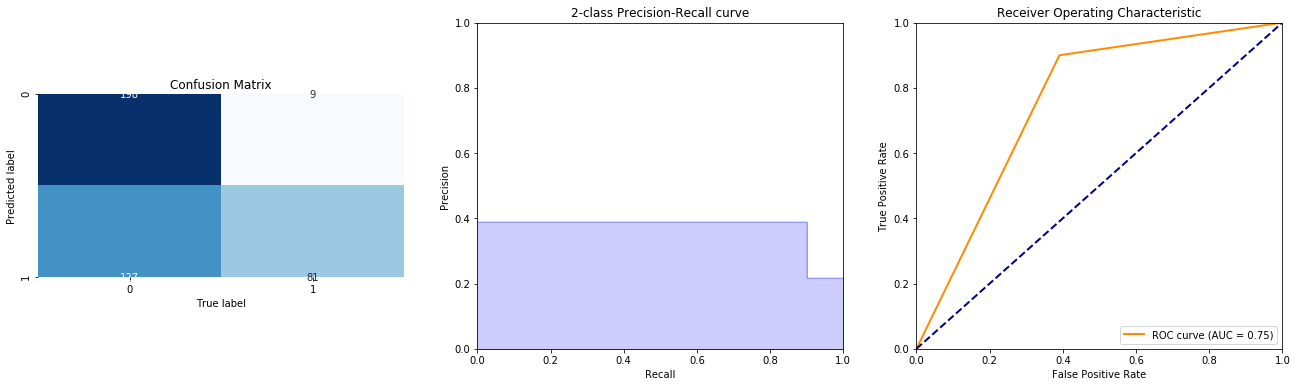


**********
* TF-IDX *
**********
Accuracy : 0.8361 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5764 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9222 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8673                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


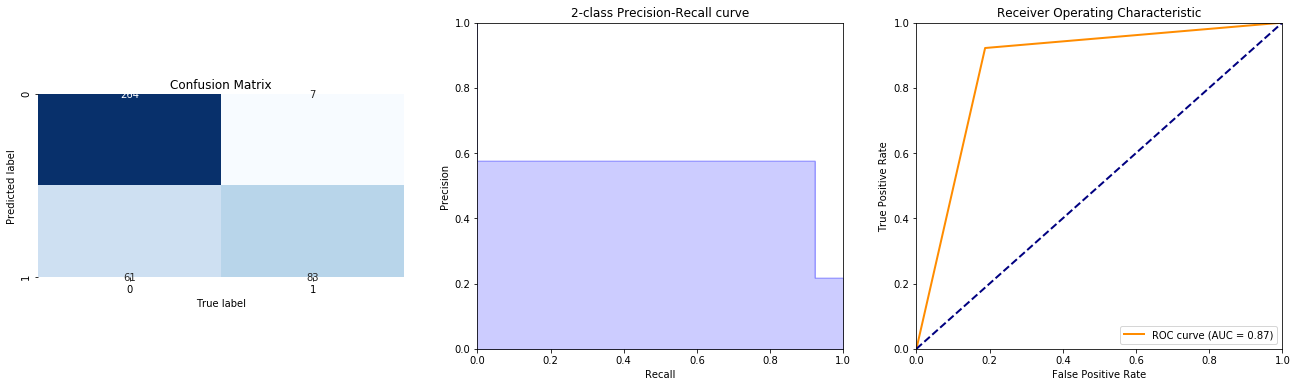

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.672289,0.389423,0.900000,0.754615
1,TF-IDX,0.836145,0.576389,0.922222,0.867265


In [96]:
#LR - 1000 iteration, applied NearMiss

nr = NearMiss()
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = nr.fit_sample(A.toarray(), y_train)
    
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000,random_state = 0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    
    print()

results

In [97]:
np.bincount(y_train)

array([310, 310])

*********
* Count *
*********
Accuracy : 0.6723 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.3894 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7546                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


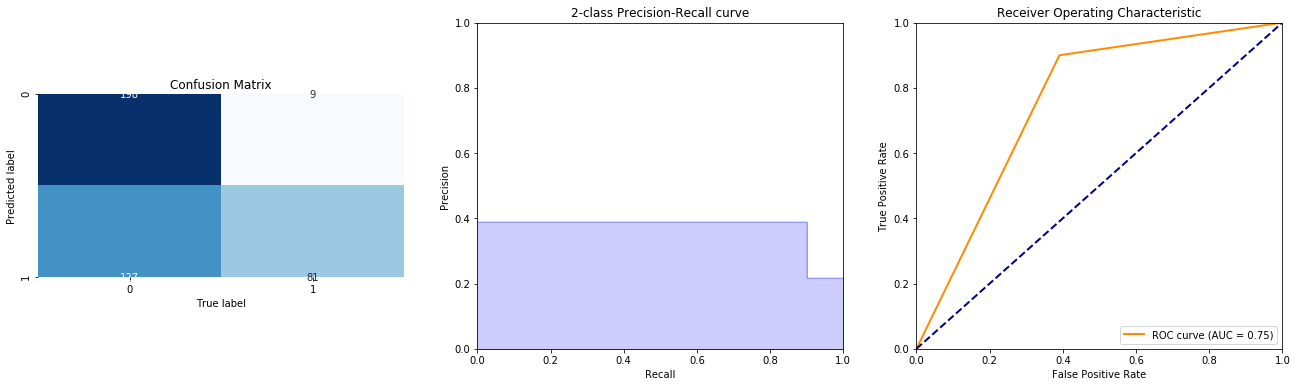


**********
* TF-IDX *
**********
Accuracy : 0.8361 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5764 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9222 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8673                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


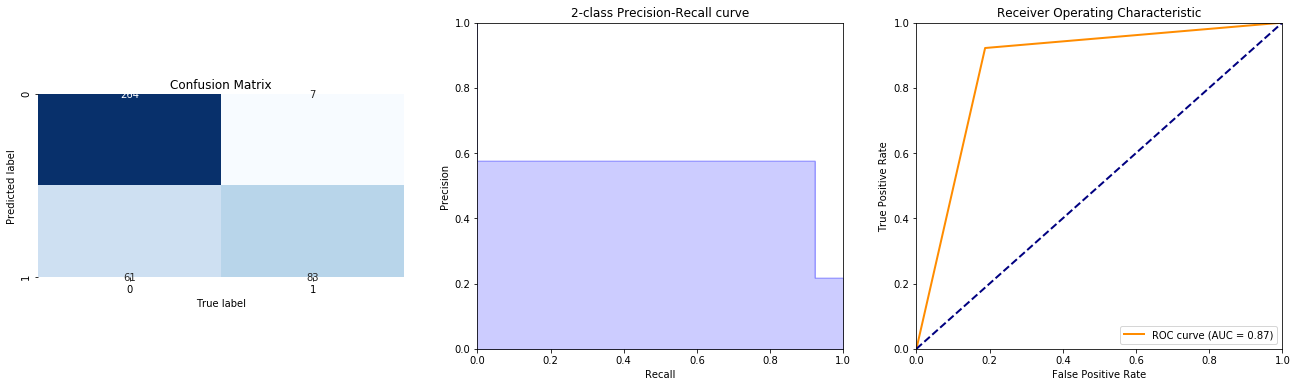

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.672289,0.389423,0.900000,0.754615
1,TF-IDX,0.836145,0.576389,0.922222,0.867265


In [98]:
#SVM - 2000 iteration, applied NearMiss

results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = nr.fit_sample(A.toarray(), y_train)
    
    Classifier = LinearSVC(C=1.0, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,verbose=0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    
    print()

results

*********
* Count *
*********
Accuracy : 0.4386 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.2759 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9778 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6335                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


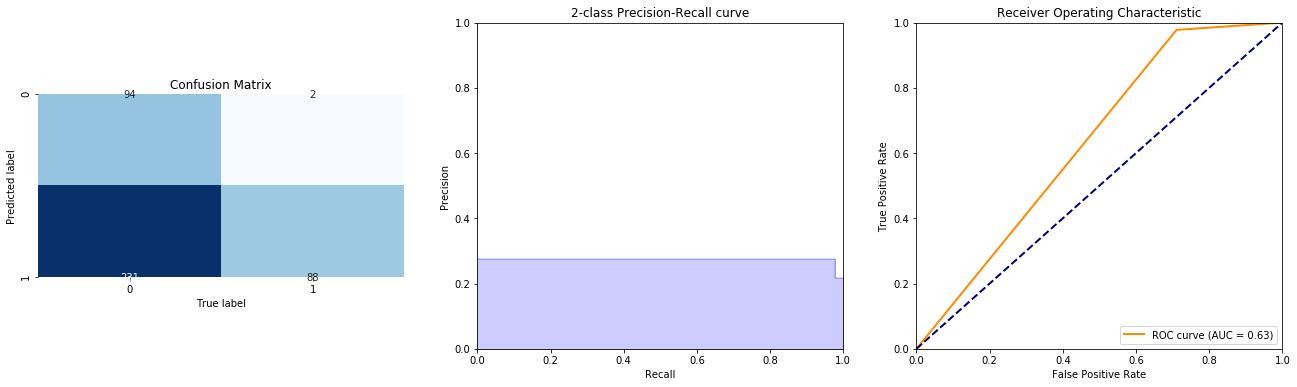


**********
* TF-IDX *
**********
Accuracy : 0.8554 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6136 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8715                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


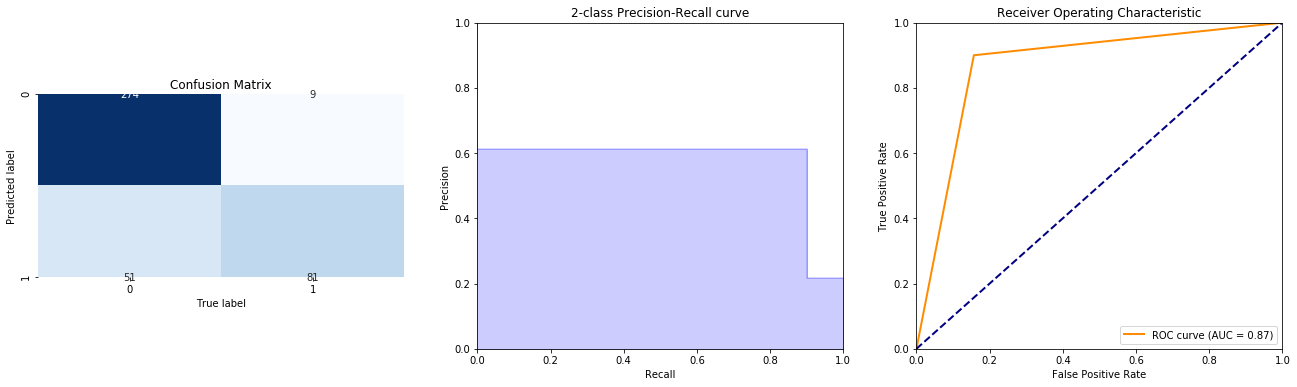

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.438554,0.275862,0.977778,0.633504
1,TF-IDX,0.855422,0.613636,0.900000,0.871538


In [99]:
# randomforest - increasing n_estimator from 500 to 1000, applying NearMiss
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    X = df1['clean_text']
    y = df1['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    counts = m
    
    A = counts.fit_transform(X_train, y_train)

    X_train_count, y_train = nr.fit_sample(A.toarray(), y_train)
    
    classifier = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    
    classifier.fit(X_train_count, y_train)
    
    predictions = classifier.predict(counts.transform(X_test))
    
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

### Adjusting stopwords

In [100]:
#removing "said","say",'thats','even' as stopwords
remove_punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~’'
nltk_stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ('said','say','thats','even')
for i in newstopwords:
    nltk_stopwords.append(i)
print(nltk_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [101]:
def clean_column(dataframe, column_to_clean, new_col):
    df_copy = dataframe.copy()
    df_copy['copied_column'] = df_copy[column_to_clean]
    df_copy['copied_column'] = df_copy['copied_column'].str.lower()
    cleaned_column = []
    for label in df_copy.index:
        row = df_copy.loc[label, :]['copied_column']
        clean = [x for x in row.split() if x not in string.punctuation]
        clean = [x for x in clean if x not in nltk_stopwords]
        clean = [x for x in clean if x not in string.digits]
        clean = [x for x in clean if x not in remove_punctuation]
        clean = [x for x in clean if len(x) != 1]
        clean = " ".join(clean)
        clean = clean.strip()
        cleaned_column.append(clean)
    df_copy[new_col] = cleaned_column
    del df_copy['copied_column']
    return df_copy

In [102]:
df2 = df1.copy()

In [103]:
# function imported from python module
df2 = clean_column(df2, 'clean_title', 'cleaned_title')
df2 = clean_column(df2, 'clean_text', 'cleaned_text')

In [104]:
word_freq = WordCloud().process_text( ' '.join(df2['cleaned_text']) ) 
top20 = sorted(word_freq.items(), key=operator.itemgetter(1), reverse=True)[:20]
top20

[('one', 2034),
 ('state', 1876),
 ('people', 1530),
 ('time', 1343),
 ('trump', 1241),
 ('new', 1194),
 ('well', 986),
 ('year', 961),
 ('may', 927),
 ('many', 911),
 ('number', 891),
 ('country', 880),
 ('make', 832),
 ('first', 828),
 ('united state', 828),
 ('company', 827),
 ('report', 825),
 ('case', 765),
 ('new york', 763),
 ('way', 759)]

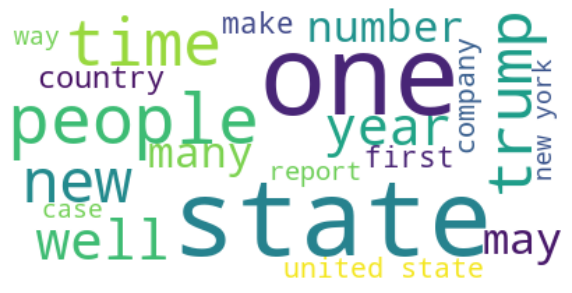

In [105]:
# plot top 20 word frequencies
wordcloud = WordCloud(max_font_size=80, max_words=20, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [106]:
# Features and Labels
X2 = df2['cleaned_text']
y2 = df2['label']

# split the dataset
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

*********
* Count *
*********
Accuracy : 0.9566 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9615 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8333 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9121                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


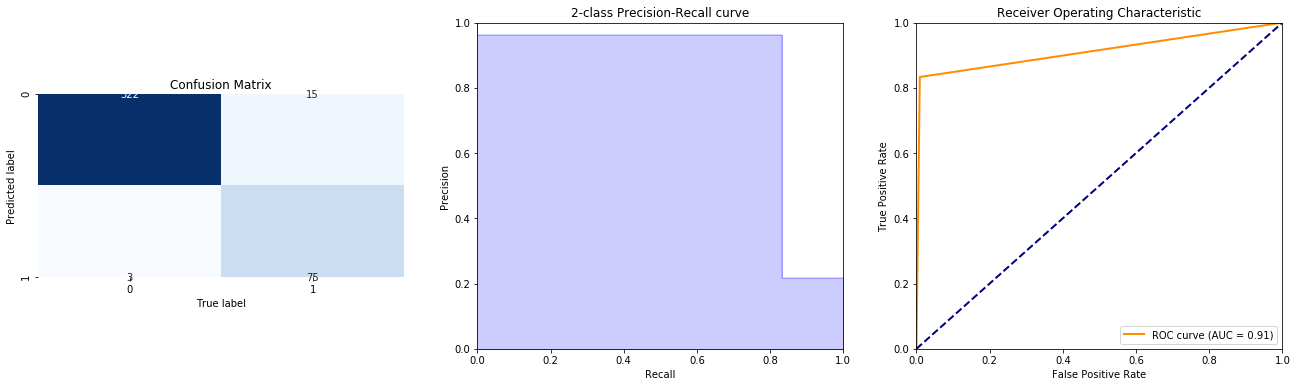


**********
* TF-IDX *
**********
Accuracy : 0.9566 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8444 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9161                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


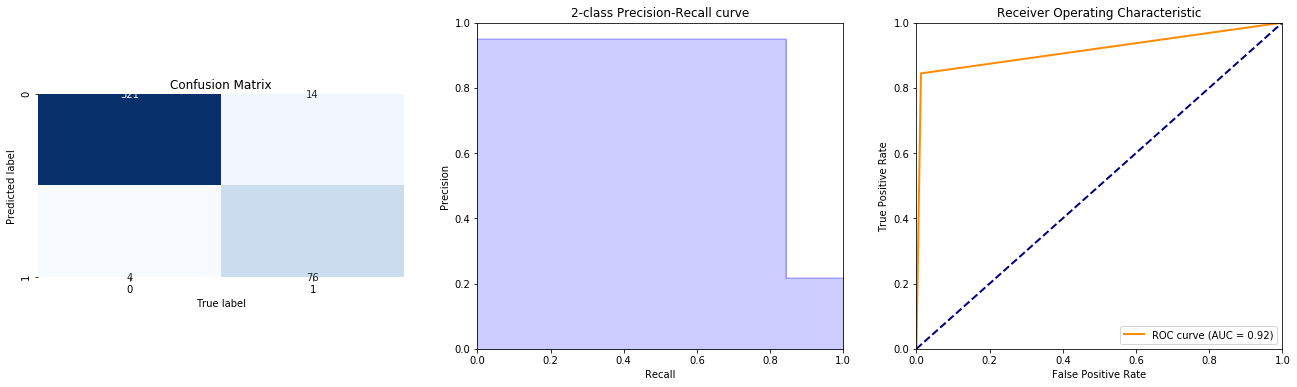

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.956627,0.961538,0.833333,0.912051
1,TF-IDX,0.956627,0.950000,0.844444,0.916068


In [107]:
# LR - increasing max_iter from 350 to 1000, adding classweight, with adjusted stopwords
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
   
    counts = m
    A = counts.fit_transform(X2_train, y2_train)
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000, class_weight={1: 4},random_state = 0)
    classifier.fit(A.toarray(), y2_train)
    B = counts.transform(X2_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9614 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9868 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8333 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9151                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


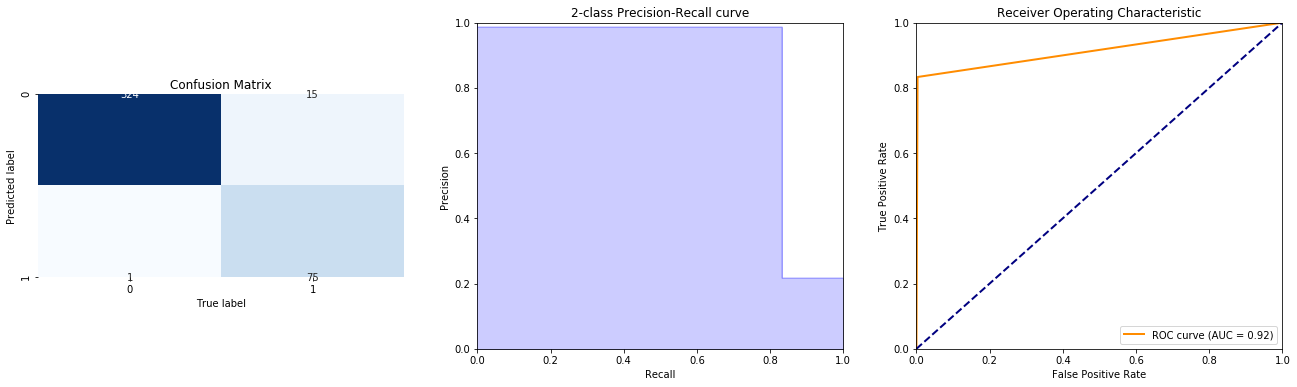


**********
* TF-IDX *
**********
Accuracy : 0.9566 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8444 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9161                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


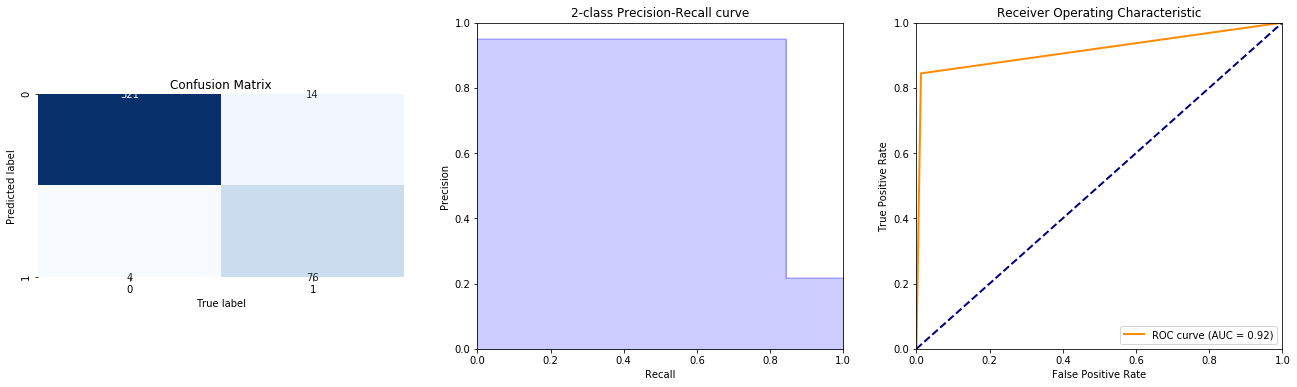

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.961446,0.986842,0.833333,0.915128
1,TF-IDX,0.956627,0.950000,0.844444,0.916068


In [108]:
# SVM - increasing max_iter from 1000 to 2000, adding class weight, with adjusted stopwords
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X2_train, y2_train)
    classifier = LinearSVC(C=1.0, class_weight={1: 4}, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000, penalty='l2', random_state=0, tol=0.0001,verbose=0)
    classifier.fit(A.toarray(), y2_train)
    B = counts.transform(X2_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9349 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8500                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


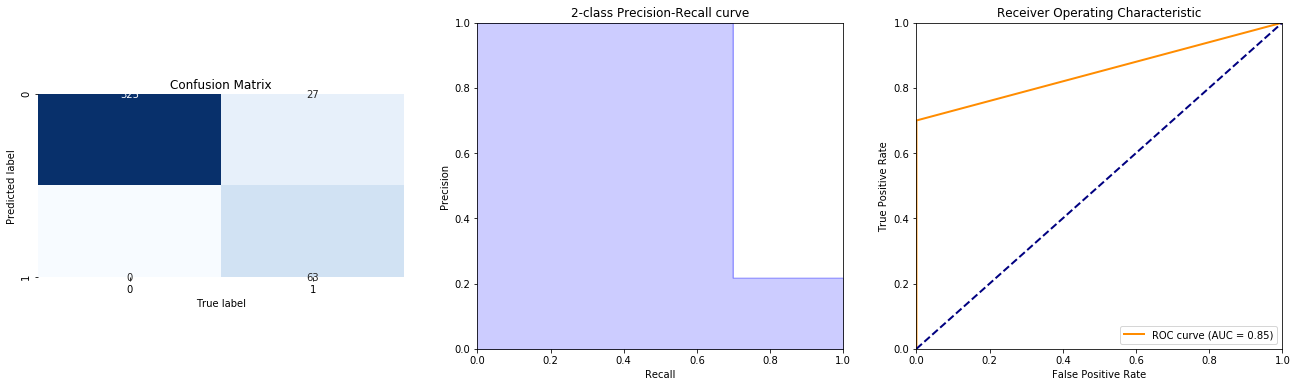


**********
* TF-IDX *
**********
Accuracy : 0.9349 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8500                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


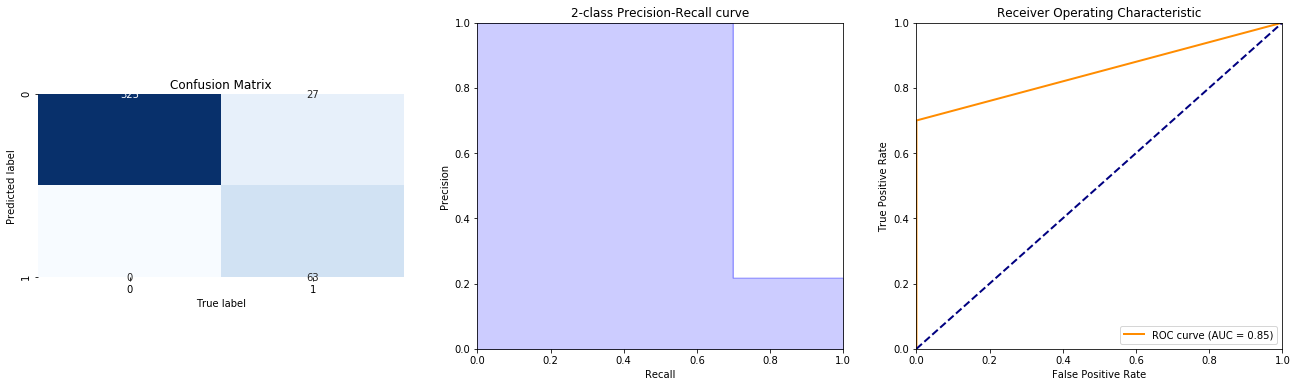

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.93494,1.0,0.7,0.85
1,TF-IDX,0.93494,1.0,0.7,0.85


In [109]:
# Randomforest - increasing n_estimator to 1000, adding class weight, with adjusted stopwords
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X2_train, y2_train)
    classifier = RandomForestClassifier(n_estimators = 1000, class_weight={1: 4}, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    classifier.fit(A.toarray(), y2_train)
    B = counts.transform(X2_test)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

In [112]:
#check feature importance to see which words are shaping the models most
count_dict = count_vect.vocabulary_
A = count_vect.fit_transform(X2_train, y2_train)
classifier = RandomForestClassifier(n_estimators = 1000, class_weight={1: 4}, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
classifier.fit(A.toarray(), y2_train)
feature_imp = pd.Series(classifier.feature_importances_).sort_values(ascending=False)[:20]
feature_imp = list(feature_imp.index)
list_feature = []
for i in feature_imp:
    a = list(count_dict.keys())[list(count_dict.values()).index(i)]
    list_feature.append(a)

list_feature

['needlessly',
 'mega',
 'onerous',
 'rousey',
 'refiled',
 'petro',
 'outrageously',
 'benioff',
 'madagascar',
 'lifetime',
 'save',
 'monica',
 'rails',
 'sailleda',
 'mapfreins',
 'molecule',
 'biodiversity',
 'charlie',
 'sarfo',
 'doral']

## Conclusion on model training & tuning

SVM after hyperparameter tuning (increased iteration, and added class weight attributes) produced the best performing results.

Next step is to assess performance on validation set.

## Validation

In [113]:
#scraped another set of articles from the same set of news websites after two weeks as validation set
fname = 'data/scraped_articles_val.json'

with open(fname) as json_data:
    d = json.load(json_data)
#These are the sources that we specified to download from in NewsPapers.json.

for i, site in enumerate((list(d['newspapers']))):
    print(i, site)

0 newyorktimes_business
1 newyorktimes_science
2 newyorktimes_technology
3 newyorktimes_politics
4 newyorktimes_world
5 cnnmoney
6 cnnpolitics
7 marketwatch_newsletters
8 cnbc_top_news
9 theguardian
10 marketwatch_stories
11 cnbc_investing
12 fox_business_latest_headlines
13 fox_business_opinion
14 entrepreneur_latest
15 entrepreneur_marketing
16 reuters_money
17 reuters_science
18 sciencedaily
19 economist_business
20 economist_science_and_tech
21 politifact-true
22 fivethirtyeight_science
23 fivethirtyeight_economics
24 dailymash
25 dailymash_politics
26 nbpostgazette
27 newsthump
28 newsthump_politics
29 newsthump_world
30 newsthump_business
31 waterfordwhispernews
32 waterfordwhispernews_politics
33 clickhole
34 clickhole_news
35 thepoke
36 thepoke_news
37 journalismday
38 satprnews
39 insidertradings
40 the onion
41 the onion_politics
42 highlandmirror
43 thefinancialanalyst
44 reportagestuff
45 huzlers
46 worldnewsdaily
47 100percentfedup
48 100percentfedup_politics
49 politifact

In [114]:
# create a dataframe, with all of the articles, one row per article

for i, site in enumerate((list(d['newspapers']))):
    articles = list(d['newspapers'][site]['articles'])
    if i == 0:
        df_val = pd.DataFrame.from_dict(articles)
    else:
        new_df = pd.DataFrame.from_dict(articles)
        df_val = pd.concat([df, new_df], ignore_index = True, sort = True)

In [115]:
df.to_pickle('/Users/Liuyang/Github/DSIA-MEL-PT-201909-LocalMaster/DSIA-MEL-PT-201910-master/Module 9/data/dirty_df_val.pkl')

In [116]:
# create a column for the label of the article, a label of 0 is ham, a label of 1 is spam
df_val['label'] = 0

In [117]:
for i, site in enumerate(spam):
    df_val.loc[df_val['link'].str.contains('{}'.format(site)), 'label'] = 1

In [118]:
# 2060 non spam articles, 400 spam articles
df_val[['title', 'label']].groupby('label').agg('count')

,title
label,
0,2033
1,400


In [119]:
remove_punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~’'
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk_stopwords.sort()
print(', '.join(nltk_stopwords))

a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, her, here, hers, herself, him, himself, his, how, i, if, in, into, is, isn, isn't, it, it's, its, itself, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she's, should, should've, shouldn, shouldn't, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, this, those, through, to, too, under, until, up, ve, very, was, wasn, wasn't, we, were, weren, weren't, what, when, where, which, while, who, whom, why, w

In [120]:
df_val1 = df_val.copy()
# function imported from python module
df_val1 = clean_column(df_val1, 'title', 'clean_title')
df_val1 = clean_column(df_val1, 'text', 'clean_text')

In [121]:
# function imported from python module
filtration(df_val1, 'clean_title')
filtration(df_val1, 'clean_text')

In [122]:
df_val1['clean_text'] = df_val1['clean_text'].apply(lambda x: lemma(x))
df_val1['clean_title'] = df_val1['clean_title'].apply(lambda x: lemma(x))
df_val1.head()

,author,label,link,published,text,title,clean_title,clean_text
0,[Kashmir Hill],0,https://www.nytimes.com/2020/01/18/technology/...,2020-01-18T20:25:19,Mr. Ton-That said his company used only public...,The Secretive Company That Might End Privacy a...,secretive company might end privacy know,mr ton that said company used publicly availab...
1,[Michael M. Grynbaum],0,https://www.nytimes.com/2020/01/19/business/me...,2020-01-19T19:18:04,News coverage of President Trump’s impeachment...,Even C-SPAN Is Piqued: Senate Puts Limits on T...,even span piqued senate put limit trial coverage,news coverage president trump impeachment tria...
2,[David Gelles],0,https://www.nytimes.com/2020/01/19/business/da...,2020-01-19T11:00:17,"Last year, one of the most talked-about exchan...","In Its 50th Year, Davos Is Searching for Its Soul",year davos searching soul,last year one talked about exchange event davo...
3,[Nicole Sperling],0,https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:09,The coming out party will feature teenagers fr...,"A New Player at Sundance, Backed by Laurene Po...",new player sundance backed laurene powell job,coming party feature teenager texas journalist...
4,[Tiffany Hsu],0,https://www.nytimes.com/2020/01/20/business/me...,2020-01-20T09:00:10,“Impeachment” is another no-no. In December 20...,"With Impeachment in the News, Ads Are Staying ...",impeachment news ad staying away politics,impeachment another no no december company blo...


In [123]:
df_val1.to_pickle('data/cleaned_df_val.pkl')

In [124]:
# Features and Labels
X_val = df_val1['clean_text']
y_val = df_val1['label']

*********
* Count *
*********
Accuracy : 0.9934 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9615 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9961                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


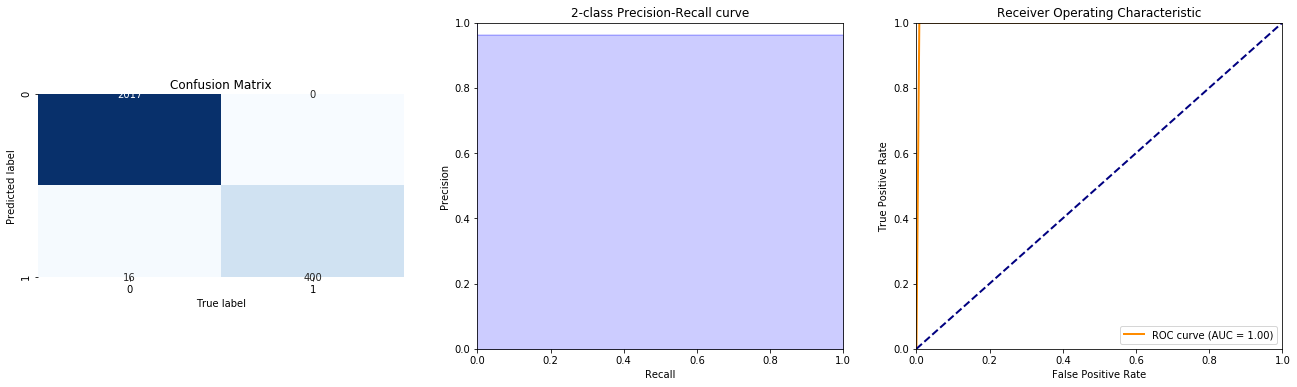


**********
* TF-IDX *
**********
Accuracy : 0.9984 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9900 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9950                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


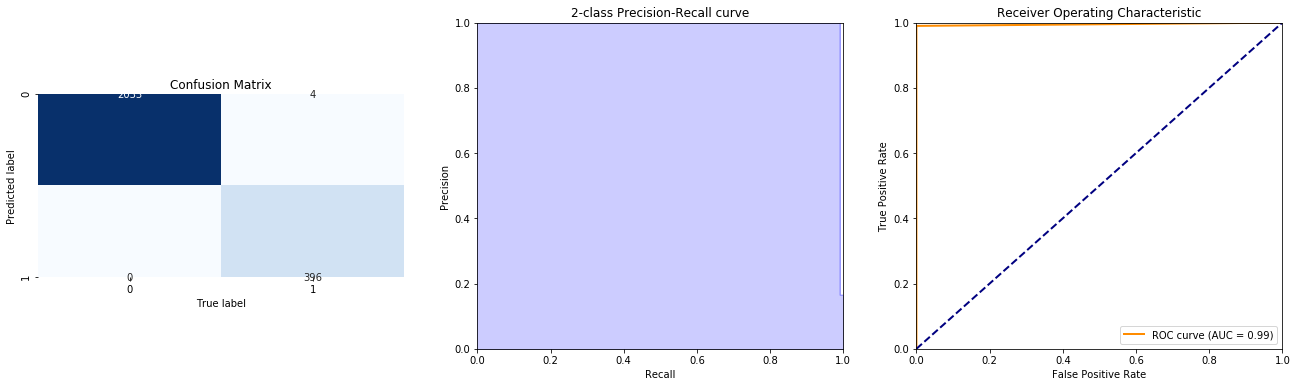

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.993424,0.961538,1.00,0.996065
1,TF-IDX,0.998356,1.000000,0.99,0.995000


In [125]:
# replicating SVM - max_iter 2000, adding class weight on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_val, y_val)
    classifier = LinearSVC(C=1.0, class_weight={1: 5}, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000, penalty='l2', random_state=0, tol=0.0001,verbose=0)
    classifier.fit(A.toarray(), y_val)
    B = counts.transform(X_val)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9984 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9900 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9950                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


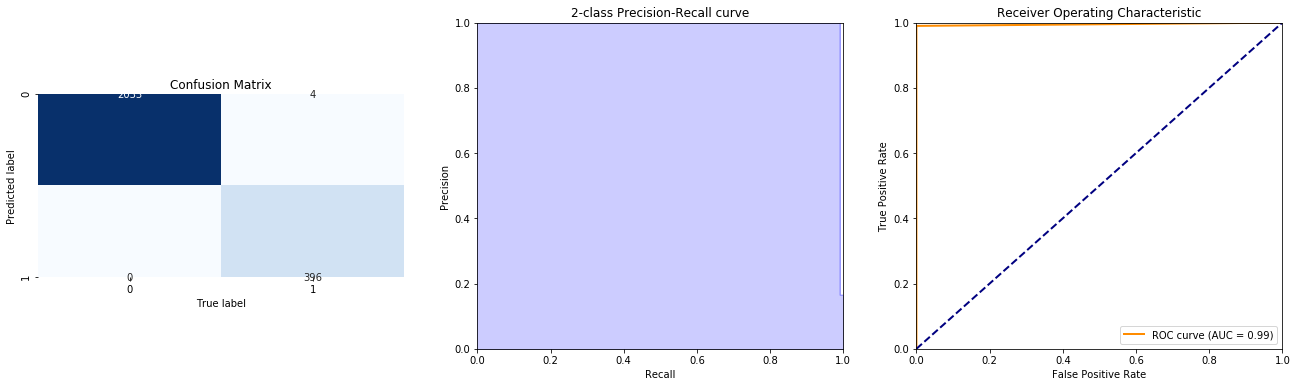


**********
* TF-IDX *
**********
Accuracy : 0.9938 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9730 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9900 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9923                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


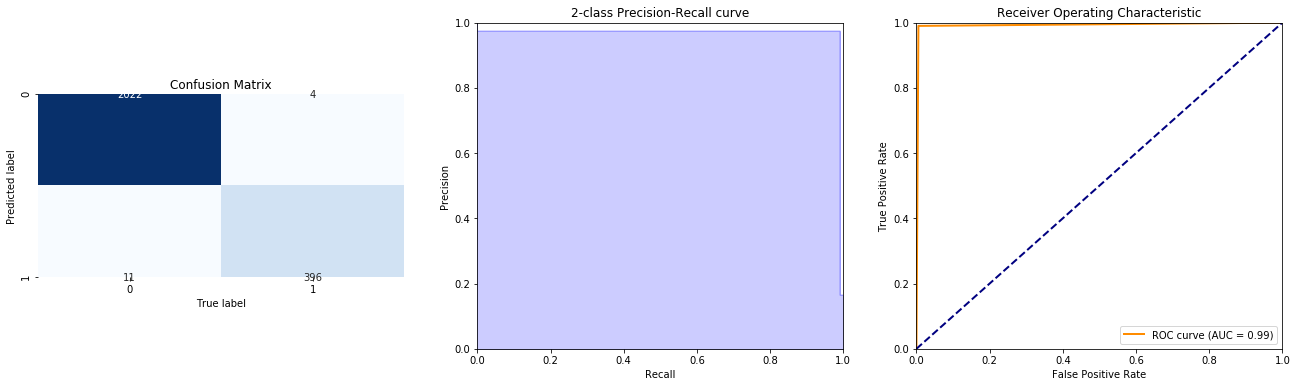

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.998356,1.000000,0.99,0.995000
1,TF-IDX,0.993835,0.972973,0.99,0.992295


In [126]:
# LR - increasing max_iter 1000, adding classweight on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_val, y_val)
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000, class_weight={1: 5},random_state = 0)
    classifier.fit(A.toarray(), y_val)
    B = counts.transform(X_val)
    predictions = classifier.predict(B)
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9934 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9615 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9961                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


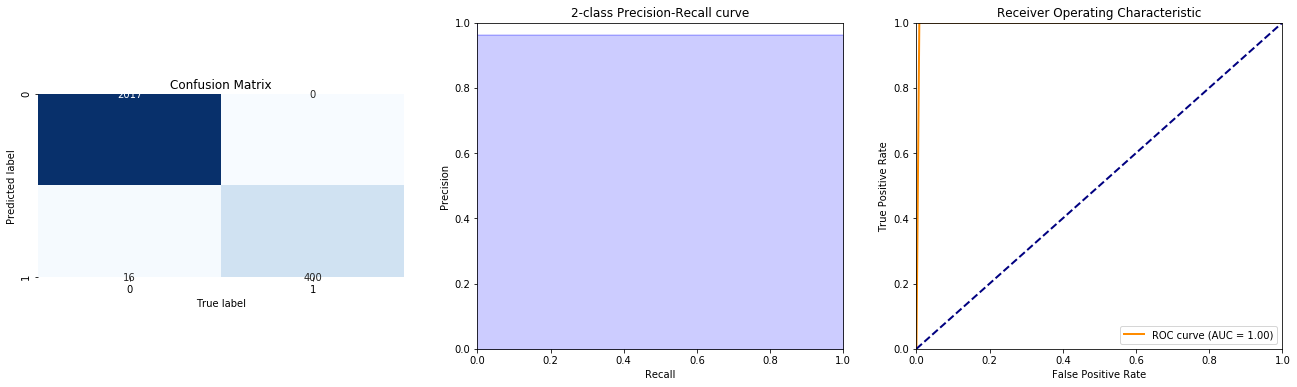


**********
* TF-IDX *
**********
Accuracy : 0.9934 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9615 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9961                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


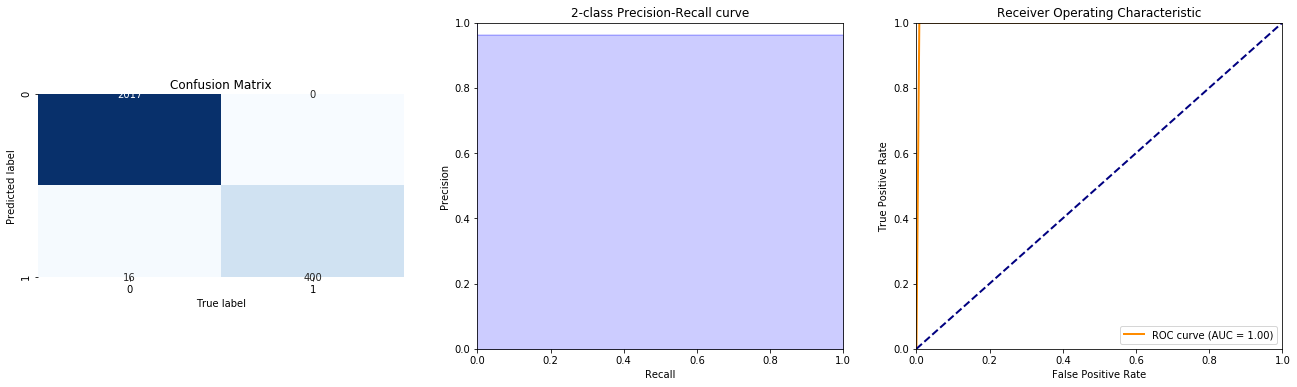

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.993424,0.961538,1.0,0.996065
1,TF-IDX,0.993424,0.961538,1.0,0.996065


In [127]:
# randomforest - n_estimator 1000, adding class weight on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_val, y_val)

    # create a classifier using SVC
    classifier = RandomForestClassifier(n_estimators = 1000, class_weight={1: 5},criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    
    # train the classifier with the training data
    classifier.fit(A.toarray(), y_val)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_val)

    # make predictions based on the test data
    predictions = classifier.predict(B)

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val, predictions)
    # keep the results
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

In [128]:
#generating additional equal classweight validation set by 
#randomly sampling 300 articles from both ham and spam in validation set
df_val1_ham = df_val1[df_val['label'] == 0]
df_val1_ham.shape

(2033, 8)

In [129]:
df_val1_spam = df_val1[df_val['label'] == 1]
df_val1_spam.shape

(400, 8)

In [130]:
df_val1_ham_trim = df_val1_ham.sample(n=300)
df_val1_ham_trim.shape

(300, 8)

In [131]:
df_val1_spam_trim = df_val1_spam.sample(n=300)
df_val1_spam_trim.shape

(300, 8)

In [132]:
df_val2 = pd.concat([df_val1_ham_trim, df_val1_spam_trim])
df_val2.shape

(600, 8)

In [134]:
# Features and Labels
X_val2 = df_val2['clean_text']
y_val2 = df_val2['label']

*********
* Count *
*********
Accuracy : 0.9983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9967 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


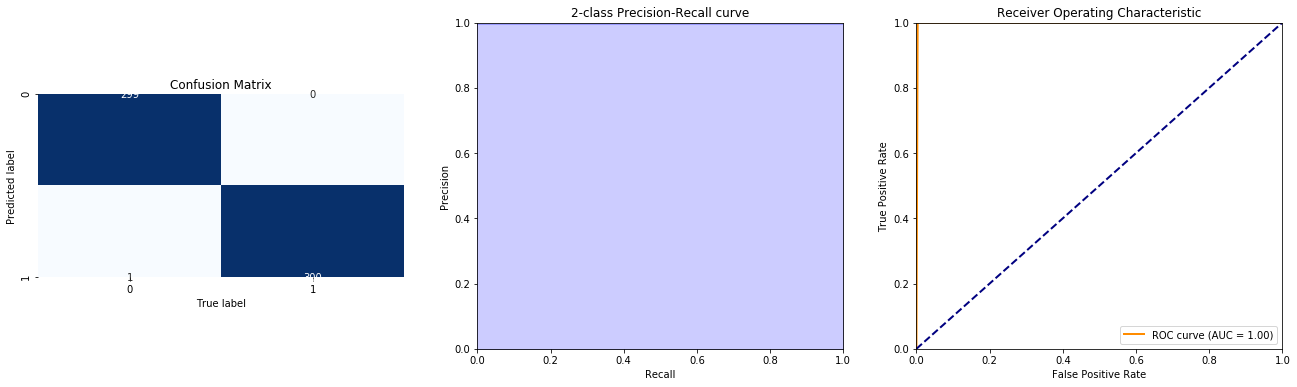


**********
* TF-IDX *
**********
Accuracy : 0.9883 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9835 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9933 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9883                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


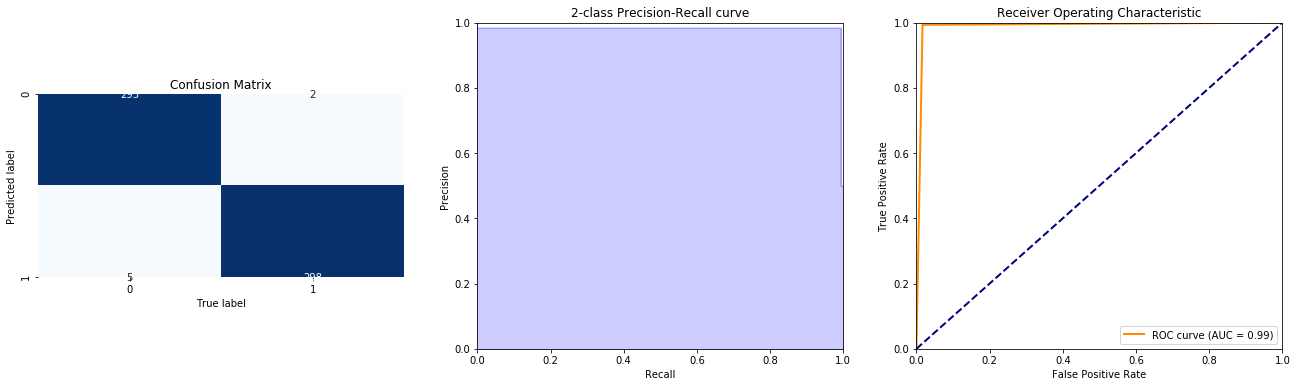

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.998333,0.996678,1.000000,0.998333
1,TF-IDX,0.988333,0.983498,0.993333,0.988333


In [135]:
# replicating LR - max_iter 1000 on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_val2, y_val2)
    classifier = LogisticRegression(solver = 'lbfgs', max_iter = 1000,random_state = 0)
    classifier.fit(A.toarray(), y_val2)
    B = counts.transform(X_val2)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val2, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9967 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


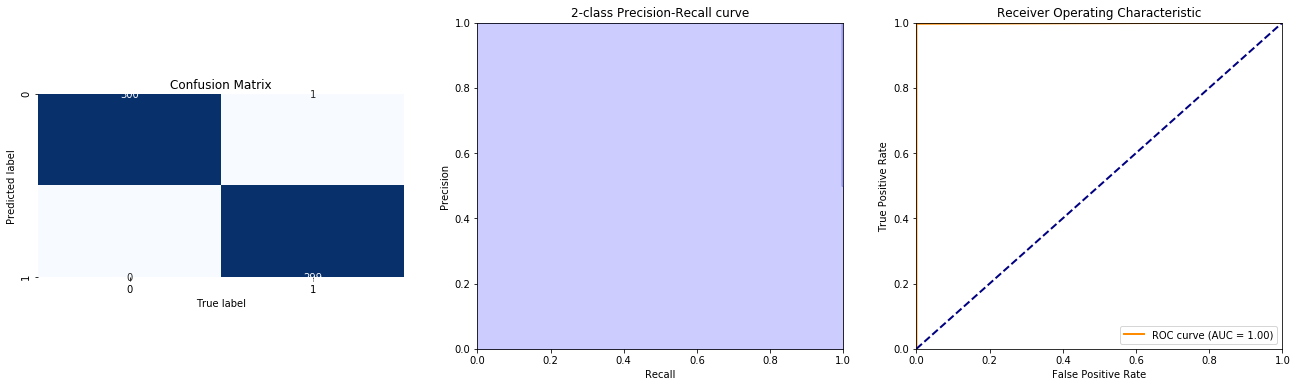


**********
* TF-IDX *
**********
Accuracy : 0.9983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9967 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


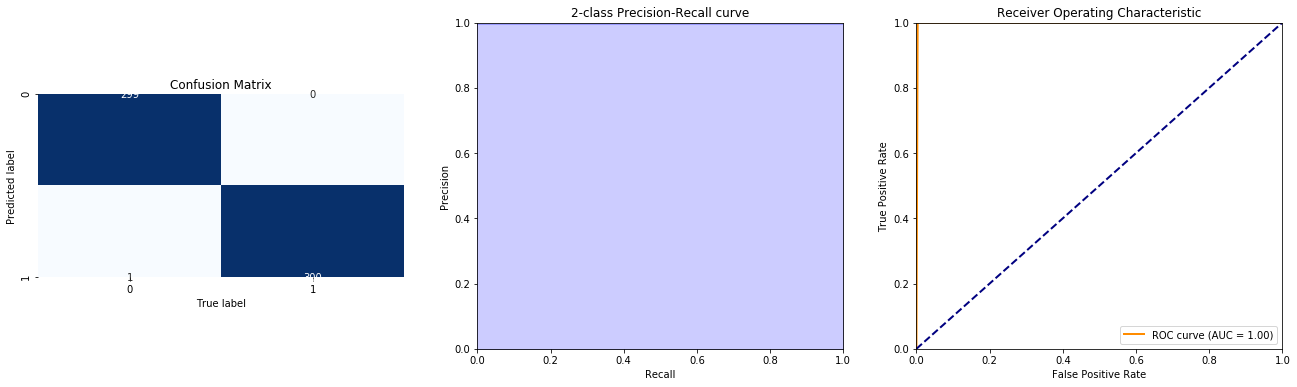

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.998333,1.000000,0.996667,0.998333
1,TF-IDX,0.998333,0.996678,1.000000,0.998333


In [136]:
# replicating SVM - max_iter 2000 on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_val2, y_val2)
    classifier = LinearSVC(C=1.0, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000, penalty='l2', random_state=0, tol=0.0001,verbose=0)
    classifier.fit(A.toarray(), y_val2)
    B = counts.transform(X_val2)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val2, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

*********
* Count *
*********
Accuracy : 0.9983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9967 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


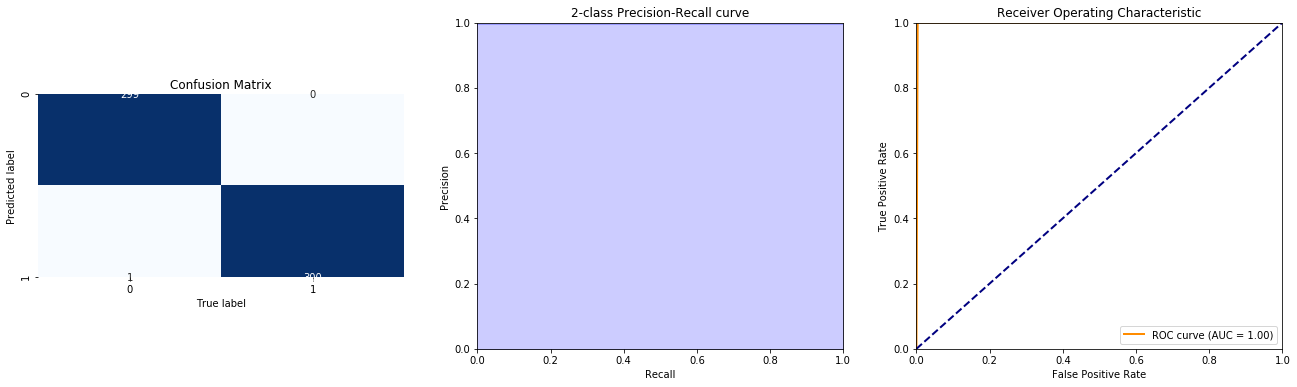


**********
* TF-IDX *
**********
Accuracy : 0.9983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9967 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9983                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


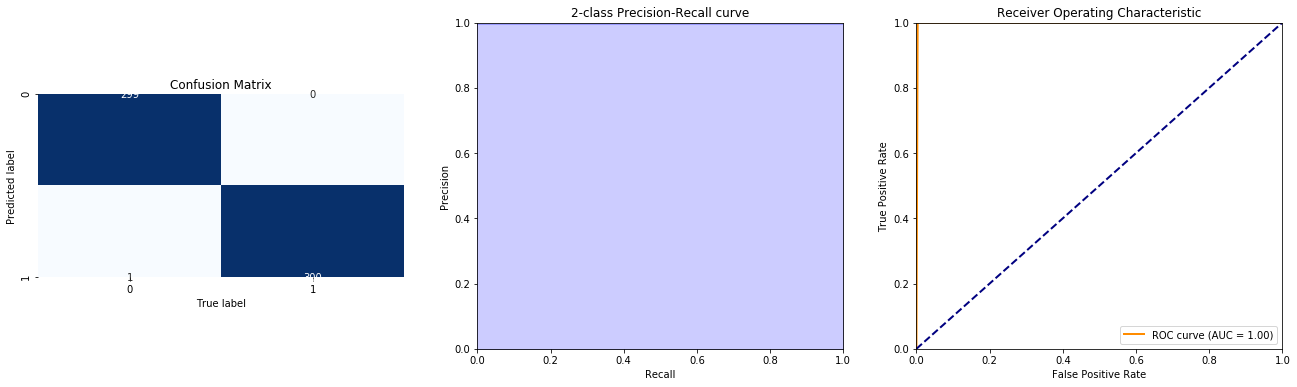

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.998333,0.996678,1.0,0.998333
1,TF-IDX,0.998333,0.996678,1.0,0.998333


In [137]:
# randomforest - n_estimator 1000 on validation set
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    
    counts = m
    A = counts.fit_transform(X_val2, y_val2)
    classifier = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth=None,
                                        max_features='auto',max_leaf_nodes=None,bootstrap=True,
                                        oob_score=False,n_jobs=None,random_state=0,verbose=0)
    classifier.fit(A.toarray(), y_val2)
    B = counts.transform(X_val2)
    predictions = classifier.predict(B)

    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_val2, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_, 
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()
    
results

## Conclusion

Logistic regression, SVM and Random Forest all performed relatively stable on validation sets.
SVM with increased iteration and added classweight being the best performing with highest accuracy and precision.